# 1. Summary

Please note that no external data was used to improve predictions, i.e. only data available in 5 files on Kaggle was used in training models.

This code file contains predictions with **CNN, LSTM, GRU** by using:

*   Just article titles (valid.accuracy capped at 75% in colab and at 72.6% in Kaggle) 
*   Article own titles + titles of incoming/outgoing references concatenated - accuracy about 80.8-81.1% in colab, 81.7-82.1% in kaggle
*   Embeddings learnt on the training set vs GloVe and Word2Vec embeddings.

Other models were implemented in separate files:

*   **Using BERT with ktrain in keras** - accuracy 75.3% in colab, 74% in kaggle using own titles only; own titles+reference titles - 81.5% acc in colab, not used for kaggle uploads due to lower accuracy than for other implementation of BERT.
*   **Using BERT in PyTorch** - accuracy using titles only: 76% in colab, 74.5% in kaggle; accuracy using own titles + titles of incoming/outgoing references: 83-85% in colab and 81.7-82.9% in kaggle (trained on whole training data for 3 epochs). **The best model produces 82.86% accuracy on kaggle**.
*   **Using text mining techniques** - accuracy using own titles only with logistic regression on TF-IDF matrix - 72% in colab and 69.6% in kaggle. Using own titles + reference titles concatenated + TF-IDF: logistic regression: 82% in colab and kaggle; multi-layer perceptron with (128,256) layers: 82.6% in kaggle (**the second-best!**).

It's interesting that using TF-IDF matrix of own titles + reference titles and a logistic regression or multilayer perceptron allows reaching higher accuracy than with most specialized NLP models except BERT and one instance of CNN. It might be due to the fact that our training data is small (12k).

# 2. Data prep

## Reading in data and installing libraries

In [ ]:
# download the repo to get access to data
!rm -rf DL-Kaggle-competition/
!git clone https://github.com/millasni/DL-Kaggle-competition/

Cloning into 'DL-Kaggle-competition'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 4), reused 23 (delta 2), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [ ]:
!pip install -q torch skorch torchvision torchtext
tf
!pip install keras
!pip install h5py
!pip3 install ktrain
!pip install NLTK
# !pip install bert-tensorflow

     |████████████████████████████████| 122kB 3.5MB/s 
     |████████████████████████████████| 25.2MB 183kB/s 
     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 983kB 42.9MB/s 
     |████████████████████████████████| 245kB 48.0MB/s 
     |████████████████████████████████| 573kB 41.7MB/s 
     |████████████████████████████████| 3.9MB 44.0MB/s 
     |████████████████████████████████| 450kB 38.9MB/s 
     |████████████████████████████████| 1.0MB 46.6MB/s 
     |████████████████████████████████| 890kB 44.2MB/s 
     |████████████████████████████████| 3.7MB 44.4MB/s 
  Created wheel for ktrain: filename=ktrain-0.13.2-cp36-none-any.whl size=25239774 sha256=8cd21c95c633677462b83ceea67cf9d62a6616a561b4cf239b70fbb38a88ccc2
  Stored in directory: /root/.cache/pip/wheels/95/fb/62/cf5424c7a9c267b78db4efacfe8b4c3a0a3f1a755f2d63e428
  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=173c1063ebf1de9df4898bd2db8d

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import skorch
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras import backend as K # or from keras...?
from tensorflow.keras.backend import concatenate

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional,SpatialDropout1D,Concatenate
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D,Dropout,Flatten,Activation

# from tensorflow.python.keras.layers import Dense
# from tensorflow.python.keras import Sequential

from keras.utils.np_utils import to_categorical 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras import optimizers
from keras.initializers import Constant
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import ktrain

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

import os

Using TensorFlow backend.


In [ ]:
train = pd.read_csv('DL-Kaggle-competition/train.csv') 
test = pd.read_csv('DL-Kaggle-competition/test.csv') 
text = pd.read_csv('DL-Kaggle-competition/text.csv') 
reference = pd.read_csv('DL-Kaggle-competition/reference.csv') 
reference_classes = pd.read_csv('DL-Kaggle-competition/ref_class_shares.csv') 
cross_ref = pd.read_csv('DL-Kaggle-competition/ref_in_out.csv') 

In [ ]:
train.head()

,id,label
0,0,1
1,3,1
2,6,1
3,8,0
4,9,0


## Data pre-processing

In [ ]:
# One-hot encode the classes in the train
Y = to_categorical(train[['label']])
print(Y.shape)
print(Y[:5])

(12779, 5)
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
print(text.head())
text.shape # we have twice as many lines in text than in train

   id                                              title
0   0  interactive visual exploration of neighbor bas...
1   1  autodomainmine a graphical data mining system ...
2   2  anipqo almost non intrusive parametric query o...
3   3  relational division four algorithms and their ...
4   4  selection and ranking of text from highly impe...


(25561, 2)

In [ ]:
train = train.join(text, how='left', on='id',  lsuffix='', rsuffix='text')
train.head()
train.tail()

,id,label,idtext,title
12774,25547,4,25547,scaling up from dialogue to multilogue some pr...
12775,25548,3,25548,a laboratory for the development and evaluatio...
12776,25554,2,25554,an analysis of transformational analogy genera...
12777,25555,2,25555,exploiting known taxonomies in learning overla...
12778,25557,1,25557,maintaining materialized views in distributed ...


In [ ]:
train = train[['id','label','title']]
train.head()


,id,label,title
0,0,1,interactive visual exploration of neighbor bas...
1,3,1,relational division four algorithms and their ...
2,6,1,simplifying xml schema effortless handling of ...
3,8,0,funbase a function based information managemen...
4,9,0,inverted matrix efficient discovery of frequen...


In [ ]:
test = test.join(text, how='left', on='id',  lsuffix='', rsuffix='text')
test.head()

,id,idtext,title
0,1,1,autodomainmine a graphical data mining system ...
1,2,2,anipqo almost non intrusive parametric query o...
2,4,4,selection and ranking of text from highly impe...
3,5,5,conditional random fields for multi agent rein...
4,7,7,multi dimensional description logics


In [ ]:
test = test[['id','title']]
test.head()

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics


In [ ]:
# tokenize train data on the whole TEXT (train+test) to see the max sent_len - - for exploration only
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text.title)
t = tokenizer.texts_to_sequences(text.title)
print(t[:10])
print(len(max(t, key=len)))
sent_len = []
for i in t:
  sent_len.append(len(i))

plt.hist(sent_len,bins=28)
plt.show()

In [ ]:
# tokenize train data (on the whole set of labeled data)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.title)
X = tokenizer.texts_to_sequences(train.title)
X = pad_sequences(X, maxlen=20)
X[:10]
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # Found 9321 unique tokens.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1234, shuffle=False)

In [ ]:
# MAKE A SECOND DATA SPLIT
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X, Y, test_size=0.2, random_state=245, shuffle=True)

In [ ]:
print(Y_train[:5])
print(Y_test[:5])

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [ ]:
# tokenize test data for Kaggle upload
X_new = tokenizer.texts_to_sequences(test.title)
X_new = pad_sequences(X_new, maxlen=20)
X_new[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    3,  482,    8,   32,   15,    1,  117,   66],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1591,  130,  758,   20,   66,    1, 1407,  295,  307],
       [   0,    0,    0,    0,    0,    0,   95,    4,  120,    2,   35,
          21,  693, 2005, 6187,    1,   24,    2,  463,  166],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  378,  229,  793,    1,   47,  278,  399,   14],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   47,  202,  302,  519],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  107,   10,  320,  284,  285,   33,  929,  593],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   76,  299, 8308],
       [   0,    0,    0,    0,    0,    

In [ ]:
# trying to find dictionary length (for the whole labelled set tokenized)
print(len(X_train))
print(np.amax(X)) 
np.amax(X)

10223
9321


9321

In [ ]:
print(X)

[[   0    0    0 ...    5    8  161]
 [   0    0    0 ...    4  415   58]
 [   0    0    0 ... 1866 1444  622]
 ...
 [   0    0    0 ...   64    4  206]
 [   0    0    0 ...   14 2086  314]
 [   0    0    0 ...    5   38   29]]


In [ ]:
# dict_len = max(max(X_train)) # for only X_train tokenized
dict_len = np.amax(X)
print(dict_len)

9321


## Making results reproducible with keras

Will repeat this setting seed exercise before each model run.

In [ ]:
# from https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# I replaced tf.set_random_seed with tf.compat.v1.set_random_seed (the former did not work)
# the same change in tf.compat.v1.ConfigProto

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

# tf.set_random_seed(1234) # this is not working
tf.compat.v1.set_random_seed(1234)
# sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

# 3. Using only own article titles

## LSTM

After trying a bunch of LSTM models with Adam and RMSprop optimizers, I keep only RMSprop result as it wins the battle and will be used thereafter. 

I also played with the learning rate and batch size for RMSprop and default lr with batch=64 gives decent results, so I will stick to them (outputs not shown).

#### Trying various basic (one hidden layer) architectures

Slight trend to growing valid. accuracy with increased emb and hidden dims.

In [ ]:
embed = [32,64,128]
hidden = [64,128,256]
drop = [0, 0.1, 0.2, 0.3]
for i in embed:
  for j in hidden:
    for k in drop:
      print('emb_dim:',i,' hidden_dim:',j, ' drop:',k,'----RMSprop')
      np.random.seed(42)
      random.seed(12345)
      session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                    inter_op_parallelism_threads=1)
      tf.compat.v1.set_random_seed(1234) 

      model = Sequential() 
      model.add(Embedding(dict_len + 1, output_dim=i)) 
      model.add(LSTM(j, dropout=k)) 
      model.add(Dense(5, activation="softmax"))  
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=7) 
      model.evaluate(X_test, Y_test)

emb_dim: 32  hidden_dim: 64  drop: 0 ----RMSprop
Epoch 1/7
160/160 [==============================] - 3s 22ms/step - loss: 1.4046 - accuracy: 0.4062 - val_loss: 1.0870 - val_accuracy: 0.5646
Epoch 2/7
160/160 [==============================] - 3s 20ms/step - loss: 0.9025 - accuracy: 0.6645 - val_loss: 0.8483 - val_accuracy: 0.6714
Epoch 3/7
160/160 [==============================] - 3s 19ms/step - loss: 0.6947 - accuracy: 0.7523 - val_loss: 0.7841 - val_accuracy: 0.7066
Epoch 4/7
160/160 [==============================] - 3s 20ms/step - loss: 0.5924 - accuracy: 0.7889 - val_loss: 0.7771 - val_accuracy: 0.7148
Epoch 5/7
160/160 [==============================] - 3s 19ms/step - loss: 0.5224 - accuracy: 0.8178 - val_loss: 0.7396 - val_accuracy: 0.7340
Epoch 6/7
160/160 [==============================] - 3s 19ms/step - loss: 0.4708 - accuracy: 0.8353 - val_loss: 0.7413 - val_accuracy: 0.7238
Epoch 7/7
80/80 [==============================] - 0s 4ms/step - loss: 0.8438 - accuracy: 0.7254
em

#### Predict on the test set for kaggle

72.085% on Kaggle vs 74.41% here

In [ ]:
# Running the best model on the test set
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model2 = Sequential() 
model2.add(Embedding(dict_len + 1, 128)) # adding trainable=True does not change the result, likely trainable by default
model2.add(LSTM(128, dropout=0.2)) 
# number of classes = 5
model2.add(Dense(5, activation="softmax"))  
model2.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [ ]:
# Train the model
model2.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=4) 
model2.evaluate(X_test, Y_test) 

Epoch 1/4
160/160 [==============================] - 11s 66ms/step - loss: 1.2273 - accuracy: 0.5234 - val_loss: 0.9097 - val_accuracy: 0.6815
Epoch 2/4
160/160 [==============================] - 10s 64ms/step - loss: 0.7507 - accuracy: 0.7302 - val_loss: 0.7609 - val_accuracy: 0.7265
Epoch 3/4
160/160 [==============================] - 10s 64ms/step - loss: 0.6068 - accuracy: 0.7877 - val_loss: 0.7455 - val_accuracy: 0.7371
Epoch 4/4
80/80 [==============================] - 1s 8ms/step - loss: 0.7365 - accuracy: 0.7441


[0.7365121841430664, 0.7441314458847046]

In [ ]:
Y_test_pred = model2.predict_classes(X_test)
Y_test_df = pd.DataFrame(Y_test)
Y_test_categ = Y_test_df.idxmax(axis=1)
confusion_matrix(Y_test_categ,Y_test_pred)

array([[374, 104,  67,  18,  25],
       [ 70, 466,  20,  27,   5],
       [ 47,  25, 405,  42,  41],
       [  9,  28,  40, 410,  15],
       [ 25,   1,  34,  11, 247]])

In [ ]:
print(Y_test)


[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [ ]:
print(Y_test_pred)

[4 3 2 ... 2 2 1]


In [ ]:
Y_new2 = model2.predict_classes(X_new)
# show the inputs and predicted outputs
print(X_new[:5])
for i in range(5):
	print("X=%s, Predicted=%s" % (X_new[i], Y_new2[i]))

[[   0    0    0    0    0    0    0    0    0    0    0    0    3  482
     8   32   15    1  117   66]
 [   0    0    0    0    0    0    0    0    0    0    0 1591  130  758
    20   66    1 1407  295  307]
 [   0    0    0    0    0    0   95    4  120    2   35   21  693 2005
  6187    1   24    2  463  166]
 [   0    0    0    0    0    0    0    0    0    0    0    0  378  229
   793    1   47  278  399   14]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   47  202  302  519]]
X=[  0   0   0   0   0   0   0   0   0   0   0   0   3 482   8  32  15   1
 117  66], Predicted=1
X=[   0    0    0    0    0    0    0    0    0    0    0 1591  130  758
   20   66    1 1407  295  307], Predicted=1
X=[   0    0    0    0    0    0   95    4  120    2   35   21  693 2005
 6187    1   24    2  463  166], Predicted=0
X=[  0   0   0   0   0   0   0   0   0   0   0   0 378 229 793   1  47 278
 399  14], Predicted=2
X=[  0   0   0   0   0   0   0   0   0   0

In [ ]:
test2 = pd.DataFrame(list(zip(test['id'], Y_new2)), 
               columns = ['id', 'label'])
test2
test2.to_csv('test2.csv',index=False)

###LSTM w 2 layers, doubling hidden_units in the second one

No gain vs 1-layer LSTM

In [ ]:
embed = [128]
hidden = [64,128,256]
drop = [0, 0.1, 0.2]
# optim = ['adam','RMSprop']
for i in embed:
  for j in hidden:
    for k in drop:
      # for l in optim:
      # print('emb_dim: ',i,' hidden_dim: ',j, ' drop: ',k, ' optim: ',l)
      print('emb_dim:',i,' hidden_dim:',j, ' drop:',k,'----RMSprop')
      np.random.seed(42)
      random.seed(12345)
      session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                    inter_op_parallelism_threads=1)
      tf.compat.v1.set_random_seed(1234) 

      model = Sequential() 
      model.add(Embedding(dict_len + 1, output_dim=i)) 
      model.add(LSTM(j, dropout=k, recurrent_dropout=0.1, return_sequences=True))
      model.add(LSTM(j*2, dropout=k, recurrent_dropout=0.1)) 
      model.add(Dense(5, activation="softmax"))  
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # Train the model
      model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
      model.evaluate(X_test, Y_test)

emb_dim: 128  hidden_dim: 64  drop: 0 ----RMSprop
Epoch 1/5
160/160 [==============================] - 17s 107ms/step - loss: 1.2005 - accuracy: 0.5063 - val_loss: 0.8927 - val_accuracy: 0.6737
Epoch 2/5
160/160 [==============================] - 16s 102ms/step - loss: 0.7358 - accuracy: 0.7362 - val_loss: 0.7685 - val_accuracy: 0.7179
Epoch 3/5
160/160 [==============================] - 16s 103ms/step - loss: 0.5843 - accuracy: 0.7909 - val_loss: 0.7500 - val_accuracy: 0.7277
Epoch 4/5
160/160 [==============================] - 16s 103ms/step - loss: 0.4949 - accuracy: 0.8240 - val_loss: 0.7609 - val_accuracy: 0.7351
Epoch 5/5
80/80 [==============================] - 1s 11ms/step - loss: 0.7902 - accuracy: 0.7304
emb_dim: 128  hidden_dim: 64  drop: 0.1 ----RMSprop
Epoch 1/5
160/160 [==============================] - 20s 123ms/step - loss: 1.2122 - accuracy: 0.5003 - val_loss: 0.9012 - val_accuracy: 0.6631
Epoch 2/5
160/160 [==============================] - 19s 120ms/step - loss: 0.75

###Bi-LSTM 

#### With 2 layers, doubling hidden_units in the second one

No gain vs one-layer LSTM

Tried also bi-LSTM with 5 layers, different emb_dim, hid_dim and dropout - no gain (even worse accuracy) - results not shown.

In [ ]:
embed = [128]
hidden = [64,128,256]
drop = [0, 0.1, 0.2]
# optim = ['adam','RMSprop']
for i in embed:
  for j in hidden:
    for k in drop:
      # for l in optim:
      # print('emb_dim: ',i,' hidden_dim: ',j, ' drop: ',k, ' optim: ',l)
      print('emb_dim:',i,' hidden_dim:',j, ' drop:',k,'----RMSprop')
      np.random.seed(42)
      random.seed(12345)
      session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                    inter_op_parallelism_threads=1)
      tf.compat.v1.set_random_seed(1234) 

      model = Sequential() 
      model.add(Embedding(dict_len + 1, output_dim=i)) 
      model.add(Bidirectional(LSTM(j, dropout=k, recurrent_dropout=0.1, return_sequences=True)))
      model.add(Bidirectional(LSTM(j*2, dropout=k, recurrent_dropout=0.1))) 
      model.add(Dense(5, activation="softmax"))  
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # Train the model
      model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
      model.evaluate(X_test, Y_test)

emb_dim: 128  hidden_dim: 64  drop: 0 ----RMSprop
Epoch 1/5
160/160 [==============================] - 36s 228ms/step - loss: 1.0897 - accuracy: 0.5615 - val_loss: 0.8242 - val_accuracy: 0.7027
Epoch 2/5
160/160 [==============================] - 36s 224ms/step - loss: 0.6882 - accuracy: 0.7567 - val_loss: 0.7650 - val_accuracy: 0.7269
Epoch 3/5
160/160 [==============================] - 36s 224ms/step - loss: 0.5561 - accuracy: 0.8067 - val_loss: 0.7366 - val_accuracy: 0.7375
Epoch 4/5
160/160 [==============================] - 35s 221ms/step - loss: 0.4653 - accuracy: 0.8377 - val_loss: 0.7847 - val_accuracy: 0.7402
Epoch 5/5
80/80 [==============================] - 2s 23ms/step - loss: 0.8228 - accuracy: 0.7277
emb_dim: 128  hidden_dim: 64  drop: 0.1 ----RMSprop
Epoch 1/5
160/160 [==============================] - 42s 262ms/step - loss: 1.1065 - accuracy: 0.5522 - val_loss: 0.8085 - val_accuracy: 0.7054
Epoch 2/5
160/160 [==============================] - 41s 258ms/step - loss: 0.69

## GRU model

In [ ]:
embed = [32,64,128]
hidden = [64,128,256]
drop = [0, 0.1, 0.2, 0.3]
for i in embed:
  for j in hidden:
    for k in drop:
      print('emb_dim:',i,' hidden_dim:',j, ' drop:',k,'----RMSprop')
      np.random.seed(42)
      random.seed(12345)
      session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                    inter_op_parallelism_threads=1)
      tf.compat.v1.set_random_seed(1234) 

      model = Sequential() 
      model.add(Embedding(dict_len + 1, output_dim=i)) 
      model.add(GRU(j, dropout=k)) 
      model.add(Dense(5, activation="softmax"))  
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # Train the model
      model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=7) 
      model.evaluate(X_test, Y_test)

emb_dim: 32  hidden_dim: 64  drop: 0 ----RMSprop
Epoch 1/7
160/160 [==============================] - 3s 19ms/step - loss: 1.3809 - accuracy: 0.4405 - val_loss: 1.0540 - val_accuracy: 0.6146
Epoch 2/7
160/160 [==============================] - 3s 17ms/step - loss: 0.8531 - accuracy: 0.6901 - val_loss: 0.8065 - val_accuracy: 0.6937
Epoch 3/7
160/160 [==============================] - 3s 16ms/step - loss: 0.6603 - accuracy: 0.7632 - val_loss: 0.7495 - val_accuracy: 0.7207
Epoch 4/7
160/160 [==============================] - 3s 17ms/step - loss: 0.5663 - accuracy: 0.8021 - val_loss: 0.7385 - val_accuracy: 0.7320
Epoch 5/7
160/160 [==============================] - 3s 16ms/step - loss: 0.5013 - accuracy: 0.8250 - val_loss: 0.7604 - val_accuracy: 0.7277
Epoch 6/7
160/160 [==============================] - 3s 16ms/step - loss: 0.4506 - accuracy: 0.8453 - val_loss: 0.7725 - val_accuracy: 0.7312
Epoch 7/7
80/80 [==============================] - 0s 3ms/step - loss: 0.8104 - accuracy: 0.7246
em

In [ ]:
# best simple GRU, learnt embeddings
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=128, name="Embedding"))  
model.add(GRU(256, dropout=0.3, name="GRU")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=4) 
model.evaluate(X_test, Y_test)

Epoch 1/4
160/160 [==============================] - 17s 104ms/step - loss: 1.1402 - accuracy: 0.5562 - val_loss: 0.8320 - val_accuracy: 0.6815
Epoch 2/4
160/160 [==============================] - 17s 103ms/step - loss: 0.7347 - accuracy: 0.7366 - val_loss: 0.7519 - val_accuracy: 0.7210
Epoch 3/4
160/160 [==============================] - 16s 103ms/step - loss: 0.6058 - accuracy: 0.7881 - val_loss: 0.7487 - val_accuracy: 0.7355
Epoch 4/4
80/80 [==============================] - 1s 19ms/step - loss: 0.7370 - accuracy: 0.7449


[0.7370414137840271, 0.7449139356613159]

In [ ]:
# GRU(256)
Y_test_pred = model.predict_classes(X_test)
Y_test_df = pd.DataFrame(Y_test)
Y_test_categ = Y_test_df.idxmax(axis=1)
confusion_matrix(Y_test_categ,Y_test_pred)

array([[403,  91,  58,  14,  22],
       [ 77, 459,  25,  22,   5],
       [ 56,  26, 400,  38,  40],
       [ 13,  29,  44, 402,  14],
       [ 33,   2,  32,  11, 240]])

In [ ]:
# LSTM-128 RMSprop
Y_test_pred = model2.predict_classes(X_test)
Y_test_df = pd.DataFrame(Y_test)
Y_test_categ = Y_test_df.idxmax(axis=1)
confusion_matrix(Y_test_categ,Y_test_pred)

array([[374, 104,  67,  18,  25],
       [ 70, 466,  20,  27,   5],
       [ 47,  25, 405,  42,  41],
       [  9,  28,  40, 410,  15],
       [ 25,   1,  34,  11, 247]])

## Models with and without GloVe

Overall, accuracy with GloVe is smaller than without (keeping everything else constant and allowing GloVe embeddings to train)

#### Getting GloVe data and matching it to our text.

Due to technical difficulties, the file was uploaded manually from the local drive

In [ ]:
# From https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html 
embeddings_index = {}
f = open('glove.6B.100d.txt')
# f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

ERROR! Session/line number was not unique in database. History logging moved to new session 65
Found 400000 word vectors.


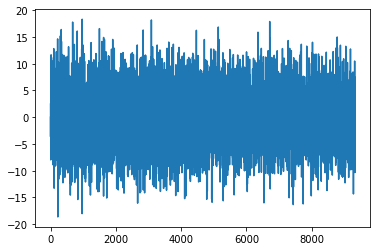

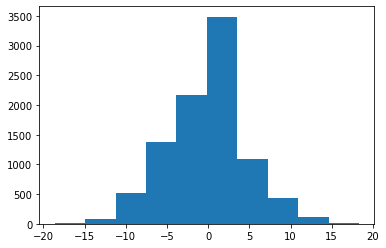

1432

In [ ]:
# Filter GloVE vectors to specific task 
def filter_glove(vocabulary_dict, glove_dict, wordvec_dim=100): 
  # Create a matrix to store the vectors 
  # 0 in vocabulary is reserved for padding    
  embedding_matrix = np.zeros((len(vocabulary_dict) + 1, wordvec_dim)) 
  for word, i in vocabulary_dict.items():
    embedding_vector = glove_dict.get(word) 
    if embedding_vector is not None:             
      # words not found in the glove_dict will be all-zeros.             
      embedding_matrix[i] = embedding_vector

  return embedding_matrix

emb_mat = filter_glove(vocabulary_dict=word_index, glove_dict=embeddings_index)
print(emb_mat[:10])
plt.plot(emb_mat.sum(axis=1))
plt.show()
plt.hist(emb_mat.sum(axis=1))
plt.show()
(emb_mat.sum(axis=1)==0).sum()

#### Trying multi-layer models with different components

With GloVe, somewhat better accuracy, but does not beat simple models above.

Smaller model (64 hidden units everywhere, 4 epochs) - 0.7269

Larger model (128 hidden units everywhere, 4 epochs) - 0.7300

With Glove, smaller (64 hu everywhere, 9 epochs) - 0.7363

With Glove, larger (128 hu everywhere, 11 epochs) - 0.7320 


In [ ]:
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=128)) 
model.add(Dense(128, activation='relu', name="Dense1")) 
model.add(Dropout(rate=0.25)) 
model.add(LSTM(64, return_sequences=True, dropout=0.15, name="LSTM")) 
model.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU")) 
model.add(Dense(64, name="Dense2")) 
model.add(Dropout(rate=0.25)) 
model.add(Dense(32, name="Dense3")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 9s 57ms/step - loss: 1.2399 - accuracy: 0.4771 - val_loss: 0.9397 - val_accuracy: 0.6416
Epoch 2/10
160/160 [==============================] - 9s 53ms/step - loss: 0.7857 - accuracy: 0.7154 - val_loss: 0.7758 - val_accuracy: 0.7250
Epoch 3/10
160/160 [==============================] - 8s 52ms/step - loss: 0.6039 - accuracy: 0.7896 - val_loss: 0.7769 - val_accuracy: 0.7218
Epoch 4/10
160/160 [==============================] - 8s 51ms/step - loss: 0.5088 - accuracy: 0.8217 - val_loss: 0.7927 - val_accuracy: 0.7269
Epoch 5/10
160/160 [==============================] - 8s 53ms/step - loss: 0.4314 - accuracy: 0.8519 - val_loss: 0.8006 - val_accuracy: 0.7230
Epoch 6/10
160/160 [==============================] - 8s 52ms/step - loss: 0.3755 - accuracy: 0.8725 - val_loss: 0.8606 - val_accuracy: 0.7136
Epoch 7/10
160/160 [==============================] - 8s 51ms/step - loss: 0.3348 - accuracy: 0.8850 - val_loss: 0.9206 - val_accuracy: 0.7097

[1.0634212493896484, 0.693270742893219]

In [ ]:
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=128)) 
model.add(Dense(128, activation='relu', name="Dense1")) 
model.add(Dropout(rate=0.25)) 
model.add(LSTM(128, return_sequences=True, dropout=0.15, name="LSTM")) 
model.add(GRU(128, return_sequences=False, dropout=0.15, name="GRU")) 
model.add(Dense(64, name="Dense2")) 
model.add(Dropout(rate=0.25)) 
model.add(Dense(32, name="Dense3")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 18s 112ms/step - loss: 1.1814 - accuracy: 0.5187 - val_loss: 0.8764 - val_accuracy: 0.6909
Epoch 2/10
160/160 [==============================] - 17s 109ms/step - loss: 0.7437 - accuracy: 0.7366 - val_loss: 0.7643 - val_accuracy: 0.7187
Epoch 3/10
160/160 [==============================] - 17s 109ms/step - loss: 0.5937 - accuracy: 0.7962 - val_loss: 0.7642 - val_accuracy: 0.7210
Epoch 4/10
160/160 [==============================] - 17s 107ms/step - loss: 0.5015 - accuracy: 0.8265 - val_loss: 0.8001 - val_accuracy: 0.7300
Epoch 5/10
160/160 [==============================] - 18s 110ms/step - loss: 0.4300 - accuracy: 0.8500 - val_loss: 0.8042 - val_accuracy: 0.7261
Epoch 6/10
160/160 [==============================] - 17s 108ms/step - loss: 0.3736 - accuracy: 0.8682 - val_loss: 0.8351 - val_accuracy: 0.7210
Epoch 7/10
160/160 [==============================] - 18s 110ms/step - loss: 0.3293 - accuracy: 0.8858 - val_loss: 0.9160 - val_ac

[1.057132601737976, 0.6893583536148071]

In [ ]:
# from DataCamp example, using pre-trained gloVe embeddings
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, trainable=True,                       
                    embeddings_initializer=Constant(emb_mat),                       
                    input_length=20, name="Embedding"))  
model.add(Dense(128, activation='relu', name="Dense1")) 
model.add(Dropout(rate=0.25)) 
model.add(LSTM(64, return_sequences=True, dropout=0.15, name="LSTM")) 
model.add(GRU(64, return_sequences=False, dropout=0.15, name="GRU")) 
model.add(Dense(64, name="Dense2")) 
model.add(Dropout(rate=0.25)) 
model.add(Dense(32, name="Dense3")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=20) 
model.evaluate(X_test, Y_test)

Epoch 1/20
160/160 [==============================] - 8s 52ms/step - loss: 1.2301 - accuracy: 0.4977 - val_loss: 0.9351 - val_accuracy: 0.6408
Epoch 2/20
160/160 [==============================] - 8s 48ms/step - loss: 0.9486 - accuracy: 0.6433 - val_loss: 0.8585 - val_accuracy: 0.6729
Epoch 3/20
160/160 [==============================] - 8s 48ms/step - loss: 0.8423 - accuracy: 0.6876 - val_loss: 0.7844 - val_accuracy: 0.7074
Epoch 4/20
160/160 [==============================] - 8s 48ms/step - loss: 0.7644 - accuracy: 0.7189 - val_loss: 0.7624 - val_accuracy: 0.7160
Epoch 5/20
160/160 [==============================] - 8s 49ms/step - loss: 0.7044 - accuracy: 0.7452 - val_loss: 0.7536 - val_accuracy: 0.7113
Epoch 6/20
160/160 [==============================] - 8s 49ms/step - loss: 0.6542 - accuracy: 0.7622 - val_loss: 0.7394 - val_accuracy: 0.7289
Epoch 7/20
160/160 [==============================] - 8s 48ms/step - loss: 0.6081 - accuracy: 0.7829 - val_loss: 0.7714 - val_accuracy: 0.7214

[0.9912737607955933, 0.714006245136261]

In [ ]:
# from DataCamp example, using pre-trained gloVe embeddings
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, trainable=True,                       
                    embeddings_initializer=Constant(emb_mat),                       
                    input_length=20, name="Embedding"))  
model.add(Dense(128, activation='relu', name="Dense1")) 
model.add(Dropout(rate=0.25)) 
model.add(LSTM(128, return_sequences=True, dropout=0.15, name="LSTM")) 
model.add(GRU(128, return_sequences=False, dropout=0.15, name="GRU")) 
model.add(Dense(128, name="Dense2")) 
model.add(Dropout(rate=0.25)) 
model.add(Dense(32, name="Dense3")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=20) 
model.evaluate(X_test, Y_test)

Epoch 1/20
160/160 [==============================] - 17s 107ms/step - loss: 1.2195 - accuracy: 0.5045 - val_loss: 0.9517 - val_accuracy: 0.6405
Epoch 2/20
160/160 [==============================] - 16s 99ms/step - loss: 0.9421 - accuracy: 0.6448 - val_loss: 0.8833 - val_accuracy: 0.6604
Epoch 3/20
160/160 [==============================] - 15s 96ms/step - loss: 0.8357 - accuracy: 0.6953 - val_loss: 0.7923 - val_accuracy: 0.7031
Epoch 4/20
160/160 [==============================] - 16s 97ms/step - loss: 0.7544 - accuracy: 0.7211 - val_loss: 0.7680 - val_accuracy: 0.7113
Epoch 5/20
160/160 [==============================] - 15s 96ms/step - loss: 0.6988 - accuracy: 0.7422 - val_loss: 0.7669 - val_accuracy: 0.7128
Epoch 6/20
160/160 [==============================] - 15s 96ms/step - loss: 0.6478 - accuracy: 0.7670 - val_loss: 0.7463 - val_accuracy: 0.7293
Epoch 7/20
160/160 [==============================] - 15s 96ms/step - loss: 0.6013 - accuracy: 0.7810 - val_loss: 0.8149 - val_accuracy

[1.0538235902786255, 0.7171361446380615]

#### Best simple LSTM (emb.dim changed from 128 to 100)

with GloVe, results are worse and the model converges longer.

No GloVe, RMSprop = 0.7437, 4 epoch

No GloVe, Adam = 0.7387, 2 epoch

GloVe, RMSprop = 0.7371, 11 epoch

GloVe, Adam = 0.7359, 8 epoch

In [ ]:
# best simple LSTM - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, name="Embedding"))  
model.add(LSTM(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 10s 60ms/step - loss: 1.2520 - accuracy: 0.5018 - val_loss: 0.9268 - val_accuracy: 0.6628
Epoch 2/10
160/160 [==============================] - 9s 57ms/step - loss: 0.7785 - accuracy: 0.7230 - val_loss: 0.7708 - val_accuracy: 0.7140
Epoch 3/10
160/160 [==============================] - 9s 58ms/step - loss: 0.6255 - accuracy: 0.7802 - val_loss: 0.7451 - val_accuracy: 0.7383
Epoch 4/10
160/160 [==============================] - 9s 58ms/step - loss: 0.5406 - accuracy: 0.8105 - val_loss: 0.7363 - val_accuracy: 0.7437
Epoch 5/10
160/160 [==============================] - 9s 57ms/step - loss: 0.4800 - accuracy: 0.8313 - val_loss: 0.7340 - val_accuracy: 0.7430
Epoch 6/10
160/160 [==============================] - 9s 57ms/step - loss: 0.4314 - accuracy: 0.8508 - val_loss: 0.7621 - val_accuracy: 0.7336
Epoch 7/10
160/160 [==============================] - 9s 57ms/step - loss: 0.3910 - accuracy: 0.8641 - val_loss: 0.7969 - val_accuracy: 0.731

[0.8794649839401245, 0.714006245136261]

In [ ]:
# best simple LSTM, using pre-trained gloVe embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, trainable=True,                       
                    embeddings_initializer=Constant(emb_mat),                       
                    input_length=20, name="Embedding"))  
model.add(LSTM(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=20) 
model.evaluate(X_test, Y_test)

Epoch 1/20
160/160 [==============================] - 8s 53ms/step - loss: 1.1676 - accuracy: 0.5338 - val_loss: 0.9576 - val_accuracy: 0.6412
Epoch 2/20
160/160 [==============================] - 8s 50ms/step - loss: 0.9285 - accuracy: 0.6498 - val_loss: 0.8785 - val_accuracy: 0.6729
Epoch 3/20
160/160 [==============================] - 8s 51ms/step - loss: 0.8227 - accuracy: 0.6894 - val_loss: 0.8080 - val_accuracy: 0.6952
Epoch 4/20
160/160 [==============================] - 8s 50ms/step - loss: 0.7499 - accuracy: 0.7180 - val_loss: 0.7703 - val_accuracy: 0.7121
Epoch 5/20
160/160 [==============================] - 8s 49ms/step - loss: 0.6889 - accuracy: 0.7418 - val_loss: 0.7500 - val_accuracy: 0.7199
Epoch 6/20
160/160 [==============================] - 8s 49ms/step - loss: 0.6421 - accuracy: 0.7611 - val_loss: 0.7392 - val_accuracy: 0.7218
Epoch 7/20
160/160 [==============================] - 8s 49ms/step - loss: 0.5968 - accuracy: 0.7786 - val_loss: 0.7649 - val_accuracy: 0.7242

[0.9929080009460449, 0.7230046987533569]

#### Best simple GRU (128 emb.dim changed to 100, GRU 256 + drop 0.3)

No GloVe = 0.7394, 4 epoch

No GloVe, with emb=128 (above) = 0.7449, 4 epoch

GloVe = 0.7324, 9 epoch

In [ ]:
# best simple GRU, no GloVe
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, name="Embedding"))  
model.add(GRU(256, dropout=0.3, name="GRU")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 16s 99ms/step - loss: 1.1915 - accuracy: 0.5300 - val_loss: 0.8594 - val_accuracy: 0.6858
Epoch 2/10
160/160 [==============================] - 15s 97ms/step - loss: 0.7509 - accuracy: 0.7357 - val_loss: 0.7548 - val_accuracy: 0.7238
Epoch 3/10
160/160 [==============================] - 16s 97ms/step - loss: 0.6149 - accuracy: 0.7855 - val_loss: 0.7388 - val_accuracy: 0.7371
Epoch 4/10
160/160 [==============================] - 15s 96ms/step - loss: 0.5363 - accuracy: 0.8123 - val_loss: 0.7342 - val_accuracy: 0.7394
Epoch 5/10
160/160 [==============================] - 16s 98ms/step - loss: 0.4830 - accuracy: 0.8277 - val_loss: 0.7527 - val_accuracy: 0.7344
Epoch 6/10
160/160 [==============================] - 16s 97ms/step - loss: 0.4335 - accuracy: 0.8462 - val_loss: 0.7761 - val_accuracy: 0.7312
Epoch 7/10
160/160 [==============================] - 16s 97ms/step - loss: 0.3904 - accuracy: 0.8654 - val_loss: 0.8043 - val_accuracy:

[0.9317275285720825, 0.7190923094749451]

In [ ]:
# best simple GRU using pre-trained gloVe embeddings
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, trainable=True,                       
                    embeddings_initializer=Constant(emb_mat),                       
                    input_length=20, name="Embedding"))  
model.add(GRU(256, dropout=0.3, name="GRU")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=20) 
model.evaluate(X_test, Y_test)

Epoch 1/20
160/160 [==============================] - 15s 91ms/step - loss: 1.1713 - accuracy: 0.5296 - val_loss: 0.9622 - val_accuracy: 0.6381
Epoch 2/20
160/160 [==============================] - 14s 88ms/step - loss: 0.9504 - accuracy: 0.6393 - val_loss: 0.8777 - val_accuracy: 0.6694
Epoch 3/20
160/160 [==============================] - 14s 89ms/step - loss: 0.8484 - accuracy: 0.6835 - val_loss: 0.7997 - val_accuracy: 0.6972
Epoch 4/20
160/160 [==============================] - 14s 88ms/step - loss: 0.7782 - accuracy: 0.7095 - val_loss: 0.7715 - val_accuracy: 0.7124
Epoch 5/20
160/160 [==============================] - 14s 88ms/step - loss: 0.7236 - accuracy: 0.7327 - val_loss: 0.7525 - val_accuracy: 0.7167
Epoch 6/20
160/160 [==============================] - 14s 88ms/step - loss: 0.6719 - accuracy: 0.7536 - val_loss: 0.7382 - val_accuracy: 0.7199
Epoch 7/20
160/160 [==============================] - 14s 88ms/step - loss: 0.6301 - accuracy: 0.7680 - val_loss: 0.7714 - val_accuracy:

[1.0766452550888062, 0.721439778804779]

## CNN

In [ ]:
# model from keras site, adapted, 250 hu, emb=128
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=128,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(250,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='valid', # 0.4 points worse with same 
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 5s 30ms/step - loss: 1.1967 - accuracy: 0.5187 - val_loss: 0.8391 - val_accuracy: 0.6941
Epoch 2/5
160/160 [==============================] - 5s 29ms/step - loss: 0.7109 - accuracy: 0.7476 - val_loss: 0.7417 - val_accuracy: 0.7328
Epoch 3/5
160/160 [==============================] - 5s 29ms/step - loss: 0.5511 - accuracy: 0.8059 - val_loss: 0.7363 - val_accuracy: 0.7430
Epoch 4/5
160/160 [==============================] - 5s 29ms/step - loss: 0.4425 - accuracy: 0.8440 - val_loss: 0.7624 - val_accuracy: 0.7367
Epoch 5/5
80/80 [==============================] - 0s 4ms/step - loss: 0.7911 - accuracy: 0.7316


[0.7911454439163208, 0.7316119074821472]

In [ ]:
# model from keras site, adapted, 250 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=100,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(250,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='valid', # 0.3p lowers with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2)) # 0.27 lower w/o dropout here
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 4s 25ms/step - loss: 1.2176 - accuracy: 0.5091 - val_loss: 0.8525 - val_accuracy: 0.6905
Epoch 2/5
160/160 [==============================] - 4s 24ms/step - loss: 0.7304 - accuracy: 0.7412 - val_loss: 0.7384 - val_accuracy: 0.7371
Epoch 3/5
160/160 [==============================] - 4s 24ms/step - loss: 0.5752 - accuracy: 0.7997 - val_loss: 0.7333 - val_accuracy: 0.7453
Epoch 4/5
160/160 [==============================] - 4s 24ms/step - loss: 0.4668 - accuracy: 0.8391 - val_loss: 0.7450 - val_accuracy: 0.7457
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 0.7805 - accuracy: 0.7359


[0.7805317640304565, 0.73591548204422]

In [ ]:
# model from keras site, adapted, 250 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=100,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(250,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 4s 26ms/step - loss: 1.1768 - accuracy: 0.5307 - val_loss: 0.8257 - val_accuracy: 0.6972
Epoch 2/5
160/160 [==============================] - 4s 25ms/step - loss: 0.7040 - accuracy: 0.7529 - val_loss: 0.7279 - val_accuracy: 0.7453
Epoch 3/5
160/160 [==============================] - 4s 25ms/step - loss: 0.5464 - accuracy: 0.8091 - val_loss: 0.7269 - val_accuracy: 0.7508
Epoch 4/5
160/160 [==============================] - 4s 25ms/step - loss: 0.4457 - accuracy: 0.8450 - val_loss: 0.7442 - val_accuracy: 0.7418
Epoch 5/5
80/80 [==============================] - 0s 3ms/step - loss: 0.7814 - accuracy: 0.7449


[0.7813548445701599, 0.7449139356613159]

In [ ]:
# model from keras site, adapted, 250 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=100,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(250,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2)) 
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 5s 28ms/step - loss: 1.2028 - accuracy: 0.5157 - val_loss: 0.8483 - val_accuracy: 0.6851
Epoch 2/5
160/160 [==============================] - 4s 28ms/step - loss: 0.7261 - accuracy: 0.7469 - val_loss: 0.7382 - val_accuracy: 0.7390
Epoch 3/5
160/160 [==============================] - 4s 28ms/step - loss: 0.5726 - accuracy: 0.8004 - val_loss: 0.7364 - val_accuracy: 0.7426
Epoch 4/5
160/160 [==============================] - 4s 28ms/step - loss: 0.4690 - accuracy: 0.8383 - val_loss: 0.7500 - val_accuracy: 0.7414
Epoch 5/5
80/80 [==============================] - 0s 4ms/step - loss: 0.7862 - accuracy: 0.7402


[0.7861568331718445, 0.7402191162109375]

In [ ]:
# with pretrained GloVe embeddings, worse.
# with trainable = False, even worse: max valid.acc = 0.682   
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=100, trainable=True,                    
                    embeddings_initializer=Constant(emb_mat),                       
                    input_length=20, name="Embedding"))  
model.add(Dropout(0.2))
model.add(Conv1D(250,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 3s 19ms/step - loss: 1.2436 - accuracy: 0.4873 - val_loss: 0.9376 - val_accuracy: 0.6534
Epoch 2/10
160/160 [==============================] - 3s 19ms/step - loss: 0.9269 - accuracy: 0.6476 - val_loss: 0.8627 - val_accuracy: 0.6729
Epoch 3/10
160/160 [==============================] - 3s 19ms/step - loss: 0.8033 - accuracy: 0.7015 - val_loss: 0.7889 - val_accuracy: 0.7015
Epoch 4/10
160/160 [==============================] - 3s 18ms/step - loss: 0.7027 - accuracy: 0.7374 - val_loss: 0.7651 - val_accuracy: 0.7152
Epoch 5/10
160/160 [==============================] - 3s 19ms/step - loss: 0.6251 - accuracy: 0.7672 - val_loss: 0.7628 - val_accuracy: 0.7203
Epoch 6/10
160/160 [==============================] - 3s 19ms/step - loss: 0.5453 - accuracy: 0.8001 - val_loss: 0.7796 - val_accuracy: 0.7171
Epoch 7/10
160/160 [==============================] - 3s 19ms/step - loss: 0.4765 - accuracy: 0.8244 - val_loss: 0.8984 - val_accuracy: 0.6843

[0.8881068229675293, 0.7057902812957764]

In [ ]:
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=128,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(50, 3,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # 0.4 points better with same
                 activation='relu',
                 strides=1))
model.add(Conv1D(100, 4,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # 0.4 points better with same
                 activation='relu',
                 strides=1))
model.add(Conv1D(150, 5,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # 0.4 points better with same
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(150))
model.add(Dense(250))
# model.add(Dropout(0.2))
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 9s 59ms/step - loss: 1.3419 - accuracy: 0.3714 - val_loss: 1.1514 - val_accuracy: 0.4734
Epoch 2/10
160/160 [==============================] - 9s 57ms/step - loss: 0.9957 - accuracy: 0.6026 - val_loss: 0.9340 - val_accuracy: 0.6448
Epoch 3/10
160/160 [==============================] - 9s 57ms/step - loss: 0.7298 - accuracy: 0.7375 - val_loss: 0.8080 - val_accuracy: 0.7062
Epoch 4/10
160/160 [==============================] - 9s 56ms/step - loss: 0.5823 - accuracy: 0.7983 - val_loss: 0.8014 - val_accuracy: 0.7250
Epoch 5/10
160/160 [==============================] - 9s 56ms/step - loss: 0.4777 - accuracy: 0.8352 - val_loss: 0.7892 - val_accuracy: 0.7226
Epoch 6/10
160/160 [==============================] - 9s 56ms/step - loss: 0.4000 - accuracy: 0.8618 - val_loss: 0.8077 - val_accuracy: 0.7261
Epoch 7/10
160/160 [==============================] - 9s 56ms/step - loss: 0.3383 - accuracy: 0.8856 - val_loss: 0.8721 - val_accuracy: 0.7152

[1.0959151983261108, 0.6936619877815247]

### Best CNN model so far

In [ ]:
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=100,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 20, 100)           932200    
_________________________________________________________________
dropout_56 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 20, 500)           150500    
_________________________________________________________________
global_max_pooling1d_56 (Glo (None, 500)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 250)               125250    
_________________________________________________________________
activation_8 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 5)               

[0.7764409780502319, 0.7445226907730103]

In [ ]:
max(history.history["val_accuracy"]) # extract mav val_accuracy from the trained model.

0.7550860643386841

#### Predict on test set for kaggle


In [ ]:
# the same, but trained for 4 epochs only to achieve max accuracy
# model from keras site, adapted, 500 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model3 = Sequential()
model3.add(Embedding(dict_len + 1, output_dim=100,
                    input_length=20))
model3.add(Dropout(0.2))
model3.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(250))
model3.add(Activation('relu'))
model3.add(Dense(5, activation="softmax"))  
model3.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model3.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=4) 
model3.evaluate(X_test, Y_test)

Epoch 1/4
160/160 [==============================] - 10s 64ms/step - loss: 1.1335 - accuracy: 0.5475 - val_loss: 0.7956 - val_accuracy: 0.7132
Epoch 2/4
160/160 [==============================] - 10s 64ms/step - loss: 0.6920 - accuracy: 0.7550 - val_loss: 0.7236 - val_accuracy: 0.7484
Epoch 3/4
160/160 [==============================] - 10s 65ms/step - loss: 0.5359 - accuracy: 0.8139 - val_loss: 0.7199 - val_accuracy: 0.7508
Epoch 4/4
80/80 [==============================] - 0s 6ms/step - loss: 0.7377 - accuracy: 0.7551


[0.7377182841300964, 0.7550860643386841]

In [ ]:
# Best CNN 
Y_test_pred = model3.predict_classes(X_test)
Y_test_df = pd.DataFrame(Y_test)
Y_test_categ = Y_test_df.idxmax(axis=1)
confusion_matrix(Y_test_categ,Y_test_pred)

array([[413,  90,  40,  13,  32],
       [ 90, 454,  18,  21,   5],
       [ 65,  18, 398,  38,  41],
       [ 12,  27,  31, 415,  17],
       [ 30,   3,  24,  11, 250]])

In [ ]:
# GRU(256)
Y_test_pred = model.predict_classes(X_test)
Y_test_df = pd.DataFrame(Y_test)
Y_test_categ = Y_test_df.idxmax(axis=1)
confusion_matrix(Y_test_categ,Y_test_pred)

array([[403,  91,  58,  14,  22],
       [ 77, 459,  25,  22,   5],
       [ 56,  26, 400,  38,  40],
       [ 13,  29,  44, 402,  14],
       [ 33,   2,  32,  11, 240]])

In [ ]:
# LSTM-128 RMSprop
Y_test_pred = model2.predict_classes(X_test)
Y_test_df = pd.DataFrame(Y_test)
Y_test_categ = Y_test_df.idxmax(axis=1)
confusion_matrix(Y_test_categ,Y_test_pred)

array([[374, 104,  67,  18,  25],
       [ 70, 466,  20,  27,   5],
       [ 47,  25, 405,  42,  41],
       [  9,  28,  40, 410,  15],
       [ 25,   1,  34,  11, 247]])

In [ ]:
Y_new3 = model3.predict_classes(X_new)
# show the inputs and predicted outputs
print(X_new[:5])
for i in range(5):
	print("X=%s, Predicted=%s" % (X_new[i], Y_new3[i]))

[[   0    0    0    0    0    0    0    0    0    0    0    0    3  482
     8   32   15    1  117   66]
 [   0    0    0    0    0    0    0    0    0    0    0 1591  130  758
    20   66    1 1407  295  307]
 [   0    0    0    0    0    0   95    4  120    2   35   21  693 2005
  6187    1   24    2  463  166]
 [   0    0    0    0    0    0    0    0    0    0    0    0  378  229
   793    1   47  278  399   14]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   47  202  302  519]]
X=[  0   0   0   0   0   0   0   0   0   0   0   0   3 482   8  32  15   1
 117  66], Predicted=1
X=[   0    0    0    0    0    0    0    0    0    0    0 1591  130  758
   20   66    1 1407  295  307], Predicted=1
X=[   0    0    0    0    0    0   95    4  120    2   35   21  693 2005
 6187    1   24    2  463  166], Predicted=0
X=[  0   0   0   0   0   0   0   0   0   0   0   0 378 229 793   1  47 278
 399  14], Predicted=2
X=[  0   0   0   0   0   0   0   0   0   0

In [ ]:
test3 = pd.DataFrame(list(zip(test['id'], Y_new3)), 
               columns = ['id', 'label'])
test3
test3.to_csv('test3.csv',index=False)

### Custom models with different filter sizes

In [ ]:
# try the best simple model for a benchmark with a new seed

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len + 1, output_dim=100,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_131 (Embedding)    (None, 20, 100)           932200    
_________________________________________________________________
dropout_121 (Dropout)        (None, 20, 100)           0         
_________________________________________________________________
conv1d_120 (Conv1D)          (None, 20, 500)           150500    
_________________________________________________________________
global_max_pooling1d_114 (Gl (None, 500)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 250)               125250    
_________________________________________________________________
activation_9 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_143 (Dense)            (None, 5)               

[0.8260191679000854, 0.7245696187019348]

In [ ]:
def custom_CNN(input_length=20,input_length2=12,vocab_size=dict_len+1,emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=500, kernel_size=2, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  # pool1 = GlobalMaxPooling1D()(drop1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=500, kernel_size=3, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  # pool2 = GlobalMaxPooling1D()(drop2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=500, kernel_size=4, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  # pool3 = GlobalMaxPooling1D()(drop3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge CNN output with reference stats
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

# define model
model = custom_CNN(input_length=20, input_length2=12, vocab_size=dict_len+1,emb_dim = 100)
model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_36"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_97 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_98 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_99 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_62 (Embedding)        (None, 20, 100)      932200      input_97[0][0]                   
___________________________________________________________________________________________

In [ ]:
def custom_CNN(input_length=20,input_length2=12,vocab_size=dict_len+1,emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=500, kernel_size=4, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.3)(conv1)
  # pool1 = GlobalMaxPooling1D()(drop1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=500, kernel_size=6, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.3)(conv2)
  # pool2 = GlobalMaxPooling1D()(drop2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=500, kernel_size=8, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.3)(conv3)
  # pool3 = GlobalMaxPooling1D()(drop3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge CNN output with reference stats
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

# define model
model = custom_CNN(input_length=20, input_length2=12, vocab_size=dict_len+1,emb_dim = 100)
model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_101 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_102 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_65 (Embedding)        (None, 20, 100)      932200      input_100[0][0]                  
___________________________________________________________________________________________

In [ ]:
# Imitating article CNN for sentense classification:
# filters: 100
# kernel size: 3,4,5
# dropout = 0.5
# MaxOverTime pooling

def custom_CNN(input_length=20,input_length2=12,vocab_size=dict_len+1,emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge CNN output with reference stats
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

# define model
model = custom_CNN(input_length=20, input_length2=12, vocab_size=dict_len+1,emb_dim = 100)
model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_107 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 20, 100)      932200      input_106[0][0]                  
___________________________________________________________________________________________

In [ ]:
# kernel size: 3,4,5
dropout = [0, 0.25, 0.35, 0.5]
filters = [50, 100, 200, 300]
# MaxOverTime pooling

for i in filters:
  for j in dropout:
    print("Number of hidden units: ", i, "dropout: ",j)

    def custom_CNN(input_length=20,input_length2=12,vocab_size=dict_len+1,emb_dim = 100):
      # define CNN layer
      inputs1 = Input(shape=(input_length,))
      emb1 = Embedding(vocab_size, emb_dim)(inputs1)
      conv1 = Conv1D(filters=i, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
      drop1 = Dropout(j)(conv1)
      pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
      # pool1 = MaxPooling1D(pool_size=2)(drop1)
      flat1 = Flatten()(pool1)

      inputs2 = Input(shape=(input_length,))
      emb2 = Embedding(vocab_size, emb_dim)(inputs2)
      conv2 = Conv1D(filters=i, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
      drop2 = Dropout(j)(conv2)
      pool2 = GlobalMaxPooling1D()(drop2)
      # pool2 = MaxPooling1D(pool_size=2)(drop2)
      flat2 = Flatten()(pool2)

      inputs3 = Input(shape=(input_length,))
      emb3 = Embedding(vocab_size, emb_dim)(inputs3)
      conv3 = Conv1D(filters=i, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
      drop3 = Dropout(j)(conv3)
      pool3 = GlobalMaxPooling1D()(drop3)
      # pool3 = MaxPooling1D(pool_size=2)(drop3)
      flat3 = Flatten()(pool3)

      # merge CNN output with reference stats
      merged = concatenate([flat1, flat2, flat3])

      dense1 = Dense(500, activation='relu')(merged)
      outputs = Dense(5, activation="softmax")(dense1)
      model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # print(model.summary())
      # plot_model(model, show_shapes=True, to_file='multichannel.png')
      return model

    np.random.seed(5)
    random.seed(5)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(5)

    # define model
    model = custom_CNN(input_length=20, input_length2=12, vocab_size=dict_len+1,emb_dim = 100)
    model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=5) 
    # save the model
    # model.save('model.h5')

Number of hidden units:  50 dropout:  0
Epoch 1/5
160/160 [==============================] - 7s 42ms/step - loss: 1.1334 - accuracy: 0.5552 - val_loss: 0.8149 - val_accuracy: 0.7066
Epoch 2/5
160/160 [==============================] - 7s 41ms/step - loss: 0.5854 - accuracy: 0.7982 - val_loss: 0.7577 - val_accuracy: 0.7351
Epoch 3/5
160/160 [==============================] - 7s 41ms/step - loss: 0.3422 - accuracy: 0.8863 - val_loss: 0.7922 - val_accuracy: 0.7285
Epoch 4/5
160/160 [==============================] - 6s 41ms/step - loss: 0.1646 - accuracy: 0.9513 - val_loss: 0.8979 - val_accuracy: 0.7257
Epoch 5/5
160/160 [==============================] - 6s 41ms/step - loss: 0.0613 - accuracy: 0.9844 - val_loss: 1.0848 - val_accuracy: 0.7148
Number of hidden units:  50 dropout:  0.25
Epoch 1/5
160/160 [==============================] - 7s 43ms/step - loss: 1.1381 - accuracy: 0.5543 - val_loss: 0.8370 - val_accuracy: 0.7105
Epoch 2/5
160/160 [==============================] - 7s 42ms/step

In [ ]:
# kernel size: 3,4,5
# removed padding = "same"
dropout = [0, 0.25, 0.35, 0.5]
filters = [50, 100, 200, 300]
# MaxOverTime pooling

for i in filters:
  for j in dropout:
    print("Number of hidden units: ", i, "dropout: ",j)

    def custom_CNN(input_length=20,input_length2=12,vocab_size=dict_len+1,emb_dim = 100):
      # define CNN layer
      inputs1 = Input(shape=(input_length,))
      emb1 = Embedding(vocab_size, emb_dim)(inputs1)
      conv1 = Conv1D(filters=i, kernel_size=3, activation='relu', strides=1)(emb1) # removed padding='same', 
      drop1 = Dropout(j)(conv1)
      pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
      # pool1 = MaxPooling1D(pool_size=2)(drop1)
      flat1 = Flatten()(pool1)

      inputs2 = Input(shape=(input_length,))
      emb2 = Embedding(vocab_size, emb_dim)(inputs2)
      conv2 = Conv1D(filters=i, kernel_size=4, activation='relu', strides=1)(emb2) # removed padding='same', 
      drop2 = Dropout(j)(conv2)
      pool2 = GlobalMaxPooling1D()(drop2)
      # pool2 = MaxPooling1D(pool_size=2)(drop2)
      flat2 = Flatten()(pool2)

      inputs3 = Input(shape=(input_length,))
      emb3 = Embedding(vocab_size, emb_dim)(inputs3)
      conv3 = Conv1D(filters=i, kernel_size=5, activation='relu', strides=1)(emb3) # removed padding='same', 
      drop3 = Dropout(j)(conv3)
      pool3 = GlobalMaxPooling1D()(drop3)
      # pool3 = MaxPooling1D(pool_size=2)(drop3)
      flat3 = Flatten()(pool3)

      # merge CNN output with reference stats
      merged = concatenate([flat1, flat2, flat3])

      dense1 = Dense(500, activation='relu')(merged)
      outputs = Dense(5, activation="softmax")(dense1)
      model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # print(model.summary())
      # plot_model(model, show_shapes=True, to_file='multichannel.png')
      return model

    np.random.seed(5)
    random.seed(5)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(5)

    # define model
    model = custom_CNN(input_length=20, input_length2=12, vocab_size=dict_len+1,emb_dim = 100)
    model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=5) 
    # save the model
    # model.save('model.h5')

Number of hidden units:  50 dropout:  0
Epoch 1/5
160/160 [==============================] - 6s 38ms/step - loss: 1.1480 - accuracy: 0.5474 - val_loss: 0.8246 - val_accuracy: 0.7023
Epoch 2/5
160/160 [==============================] - 6s 38ms/step - loss: 0.5914 - accuracy: 0.7934 - val_loss: 0.7591 - val_accuracy: 0.7261
Epoch 3/5
160/160 [==============================] - 6s 37ms/step - loss: 0.3412 - accuracy: 0.8858 - val_loss: 0.7892 - val_accuracy: 0.7222
Epoch 4/5
160/160 [==============================] - 6s 37ms/step - loss: 0.1599 - accuracy: 0.9521 - val_loss: 0.9036 - val_accuracy: 0.7257
Epoch 5/5
160/160 [==============================] - 6s 37ms/step - loss: 0.0597 - accuracy: 0.9848 - val_loss: 1.0869 - val_accuracy: 0.7105
Number of hidden units:  50 dropout:  0.25
Epoch 1/5
160/160 [==============================] - 6s 38ms/step - loss: 1.1609 - accuracy: 0.5361 - val_loss: 0.8568 - val_accuracy: 0.7031
Epoch 2/5
160/160 [==============================] - 6s 38ms/step

In [ ]:
# This one no good!
# kernel size: 4,6,8 - CHANGED
# Increased stride in layers with wider kernels to 1-2-3
# MaxOverTime pooling

dropout = [0, 0.25, 0.35, 0.5]
filters = [50, 100, 200, 300]
# MaxOverTime pooling

for i in filters:
  for j in dropout:
    print("Number of hidden units: ", i, "dropout: ",j)

    def custom_CNN(input_length=20,input_length2=12,vocab_size=dict_len+1,emb_dim = 100):
      # define CNN layer
      inputs1 = Input(shape=(input_length,))
      emb1 = Embedding(vocab_size, emb_dim)(inputs1)
      conv1 = Conv1D(filters=i, kernel_size=4, padding='same', activation='relu', strides=1)(emb1)
      drop1 = Dropout(j)(conv1)
      pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
      # pool1 = MaxPooling1D(pool_size=2)(drop1)
      flat1 = Flatten()(pool1)

      inputs2 = Input(shape=(input_length,))
      emb2 = Embedding(vocab_size, emb_dim)(inputs2)
      conv2 = Conv1D(filters=i, kernel_size=6, padding='same', activation='relu', strides=2)(emb2)
      drop2 = Dropout(j)(conv2)
      pool2 = GlobalMaxPooling1D()(drop2)
      # pool2 = MaxPooling1D(pool_size=2)(drop2)
      flat2 = Flatten()(pool2)

      inputs3 = Input(shape=(input_length,))
      emb3 = Embedding(vocab_size, emb_dim)(inputs3)
      conv3 = Conv1D(filters=i, kernel_size=8, padding='same', activation='relu', strides=3)(emb3)
      drop3 = Dropout(j)(conv3)
      pool3 = GlobalMaxPooling1D()(drop3)
      # pool3 = MaxPooling1D(pool_size=2)(drop3)
      flat3 = Flatten()(pool3)

      # merge CNN output with reference stats
      merged = concatenate([flat1, flat2, flat3])

      dense1 = Dense(500, activation='relu')(merged)
      outputs = Dense(5, activation="softmax")(dense1)
      model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # print(model.summary())
      # plot_model(model, show_shapes=True, to_file='multichannel.png')
      return model

    np.random.seed(5)
    random.seed(5)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(5)

    # define model
    model = custom_CNN(input_length=20, input_length2=12, vocab_size=dict_len+1,emb_dim = 100)
    model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=5) 
    # save the model
    # model.save('model.h5')

Number of hidden units:  50 dropout:  0
Epoch 1/5
160/160 [==============================] - 6s 37ms/step - loss: 1.1470 - accuracy: 0.5436 - val_loss: 0.8073 - val_accuracy: 0.7128
Epoch 2/5
160/160 [==============================] - 6s 37ms/step - loss: 0.5631 - accuracy: 0.8037 - val_loss: 0.7626 - val_accuracy: 0.7312
Epoch 3/5
160/160 [==============================] - 6s 36ms/step - loss: 0.2927 - accuracy: 0.9044 - val_loss: 0.8308 - val_accuracy: 0.7167
Epoch 4/5
160/160 [==============================] - 6s 36ms/step - loss: 0.1130 - accuracy: 0.9686 - val_loss: 1.0286 - val_accuracy: 0.6999
Epoch 5/5
160/160 [==============================] - 6s 36ms/step - loss: 0.0328 - accuracy: 0.9922 - val_loss: 1.2906 - val_accuracy: 0.6929
Number of hidden units:  50 dropout:  0.25
Epoch 1/5
160/160 [==============================] - 6s 37ms/step - loss: 1.1553 - accuracy: 0.5382 - val_loss: 0.8373 - val_accuracy: 0.7050
Epoch 2/5
160/160 [==============================] - 6s 36ms/step

## Using CV: results closer to Kaggle 

Summary:

Best CNN, one layer (emb = 100, 500 hu in Conv1D, 250 in Dense) - **72.6% on Kaggle**

 * CV seed 10: 73.82% (+/- 1.49%)
 * CV seed 1234: 73.65% (+/- 1.13%)

 
 Best GRU: Emb=128, GRU=256 - **72.38% on Kaggle (with Word2Vec embeddings)**
 
 * dropout=0, CV seed 10: 73.14% (+/- 1.18%)
 * dropout=0.3, CV seed 10: 73.38% (+/- 1.26%)

### CNN

In [ ]:
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len + 1, output_dim=100,
                      input_length=20))
  model.add(Dropout(0.2))
  model.add(Conv1D(500,3,
                  padding='same', 
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(250))
  # model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
  model.add(Activation('relu'))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint] 
  # earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=callbacks_list,verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)	



Epoch 00001: val_accuracy improved from -inf to 0.70657, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.70657 to 0.71049, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.71049 to 0.72770, saving model to weights.best.hdf5

Epoch 00004: val_accuracy did not improve from 0.72770

Epoch 00005: val_accuracy improved from 0.72770 to 0.73161, saving model to weights.best.hdf5

Epoch 00006: val_accuracy did not improve from 0.73161

Epoch 00007: val_accuracy did not improve from 0.73161
accuracy: 73.16%

Epoch 00001: val_accuracy improved from -inf to 0.68936, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.68936 to 0.73005, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.73005 to 0.73083, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.73083 to 0.73474, saving model to weights.best.hdf5

Epoch 00005: val_accuracy improved from 0.73474 to 0.73709, 

73.82% (+/- 1.49%)


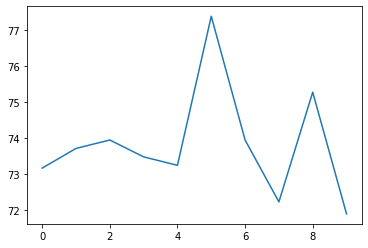

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

In [ ]:
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len + 1, output_dim=100,
                      input_length=20))
  model.add(Dropout(0.2))
  model.add(Conv1D(500,3,
                  padding='same', 
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(250))
  # model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
  model.add(Activation('relu'))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint] 
  # earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=callbacks_list,verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)


Epoch 00001: val_accuracy improved from -inf to 0.69797, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.69797 to 0.72222, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.72222 to 0.73318, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.73318 to 0.74022, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.74022

Epoch 00006: val_accuracy did not improve from 0.74022

Epoch 00007: val_accuracy did not improve from 0.74022
accuracy: 74.02%

Epoch 00001: val_accuracy improved from -inf to 0.69484, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.69484 to 0.72457, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.72457 to 0.73083, saving model to weights.best.hdf5

Epoch 00004: val_accuracy did not improve from 0.73083

Epoch 00005: val_accuracy did not improve from 0.73083

Epoch 00006: val_accuracy did not improve f

73.65% (+/- 1.13%)


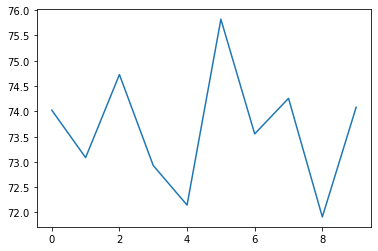

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

In [ ]:
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len + 1, output_dim=128,
                      input_length=20))
  model.add(Dropout(0.2))
  model.add(Conv1D(50, 3,
  #  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                  padding='same', # 0.4 points better with same
                  activation='relu',
                  strides=1))
  model.add(Conv1D(100, 4,
                  padding='same',
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(250))
  # model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
  model.add(Activation('relu'))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint] 
  # earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=callbacks_list,verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)


Epoch 00001: val_accuracy improved from -inf to 0.67136, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.67136 to 0.68388, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.68388 to 0.73005, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.73005 to 0.74648, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.74648

Epoch 00006: val_accuracy did not improve from 0.74648

Epoch 00007: val_accuracy did not improve from 0.74648
accuracy: 74.65%

Epoch 00001: val_accuracy improved from -inf to 0.59937, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.59937 to 0.70501, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.70501 to 0.72457, saving model to weights.best.hdf5

Epoch 00004: val_accuracy did not improve from 0.72457

Epoch 00005: val_accuracy did not improve from 0.72457

Epoch 00006: val_accuracy did not improve f

73.20% (+/- 1.50%)


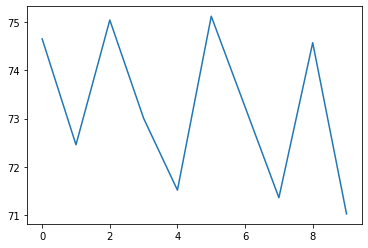

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

In [ ]:
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len + 1, output_dim=128,
                      input_length=20))
  model.add(Dropout(0.2))
  model.add(Conv1D(50, 3,
  #  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                  padding='same', # 0.4 points better with same
                  activation='relu',
                  strides=1))
  model.add(Conv1D(100, 4,
                  padding='same',
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(250))
  # model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
  model.add(Activation('relu'))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=[earlystop, checkpoint],verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)


Epoch 00001: val_accuracy improved from -inf to 0.67136, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.67136 to 0.68388, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.68388 to 0.73005, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.73005 to 0.74648, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.74648
Epoch 00005: early stopping
accuracy: 74.65%

Epoch 00001: val_accuracy improved from -inf to 0.59937, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.59937 to 0.70501, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.70501 to 0.72457, saving model to weights.best.hdf5

Epoch 00004: val_accuracy did not improve from 0.72457
Epoch 00004: early stopping
accuracy: 72.46%

Epoch 00001: val_accuracy improved from -inf to 0.70266, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.7026

73.08% (+/- 1.70%)


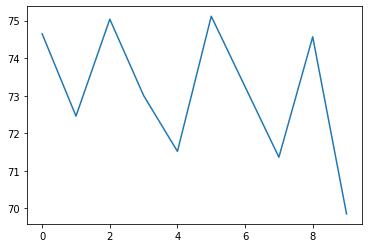

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

### GRU

Emb=128, GRU=256, drop=0 or drop=0.3


In [ ]:
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len + 1, output_dim=128)) 
  model.add(GRU(256, dropout=0)) 
  model.add(Dense(5, activation="softmax"))  
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint] 
  # earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=callbacks_list,verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)

ERROR! Session/line number was not unique in database. History logging moved to new session 60

Epoch 00001: val_accuracy improved from -inf to 0.69014, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.69014 to 0.71831, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.71831 to 0.72144, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.72144 to 0.73239, saving model to weights.best.hdf5

Epoch 00005: val_accuracy improved from 0.73239 to 0.73474, saving model to weights.best.hdf5

Epoch 00006: val_accuracy did not improve from 0.73474

Epoch 00007: val_accuracy did not improve from 0.73474
accuracy: 73.47%

Epoch 00001: val_accuracy improved from -inf to 0.70736, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.70736 to 0.72222, saving model to weights.best.hdf5

Epoch 00003: val_accuracy did not improve from 0.72222

Epoch 00004: val_accuracy improved from 0.72222 to 0.73396, 

73.14% (+/- 1.18%)


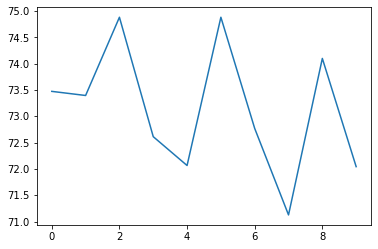

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

In [ ]:
# DROPOUT increased from 0 to 0.3
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len + 1, output_dim=128)) 
  model.add(GRU(256, dropout=0.3)) 
  model.add(Dense(5, activation="softmax"))  
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint] 
  # earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=callbacks_list,verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)	


Epoch 00002: val_accuracy improved from 0.68701 to 0.70266, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.70266 to 0.72222, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.72222 to 0.74257, saving model to weights.best.hdf5

Epoch 00005: val_accuracy improved from 0.74257 to 0.74883, saving model to weights.best.hdf5

Epoch 00006: val_accuracy did not improve from 0.74883

Epoch 00007: val_accuracy did not improve from 0.74883
accuracy: 74.88%

Epoch 00001: val_accuracy improved from -inf to 0.69405, saving model to weights.best.hdf5

Epoch 00002: val_accuracy improved from 0.69405 to 0.71283, saving model to weights.best.hdf5

Epoch 00003: val_accuracy improved from 0.71283 to 0.71596, saving model to weights.best.hdf5

Epoch 00004: val_accuracy improved from 0.71596 to 0.73083, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.73083

Epoch 00006: val_accuracy did not improve from 0.73083

E

73.38% (+/- 1.26%)


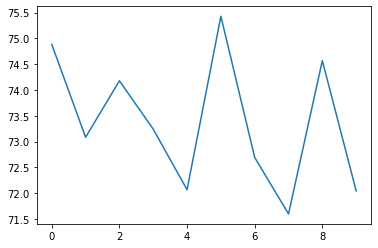

In [ ]:
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
plt.plot(cvscores)
plt.show()

## Using Word2Vec by Google

Incrementally better with Word2Vec in LSTM and CNN

LSTM emb=300, 128 hu, dropout = 0.2:

 * no pre-trained emb: 0.7410
 * with Word2Vec: 0.7423

CNN emb = 300, 500 hum 250 in Dense

 * no pre-trained emb: 0.7426
 * with Word2Vec:0.7453

GRU emb=300, 256 hu in GRU, dropout = 0.3: 0.7410/0.7406

GRU emb=300, 128 hu in GRU, dropout = 0.3: 0.7422/0.7422

GRU emb=300, 128 hu in GRU, dropout = 0.2: 0.7426/0.7430


#### Splitting data again: making dictionary only on the train set (minus validation)

In [ ]:
title_train, title_test, Y_train, Y_test = train_test_split(
    train.title, Y, test_size=0.2, random_state=1234, shuffle=False)

In [ ]:
title_train[:10]

0    interactive visual exploration of neighbor bas...
1    relational division four algorithms and their ...
2    simplifying xml schema effortless handling of ...
3    funbase a function based information managemen...
4    inverted matrix efficient discovery of frequen...
5    computational aspects of covering in dominance...
6    feaspar   a feature structure parser learning ...
7    assessing the scenic route measuring the value...
8    webanywhere enabling a screen reading interfac...
9    non standard semantics for the method of tempo...
Name: title, dtype: object

In [ ]:
# tokenize train data
NUM_WORDS = 10000 # keep top 10000 words in a dictionary, can be changed later
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(title_train)
X_train = tokenizer.texts_to_sequences(title_train)
X_train = pad_sequences(X_train, maxlen=20)
X_train[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  157,
         255,  406,    2,  847,    9,  123,    5,    8,  191],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   46, 2062, 1460,   64,    4,  421,   56],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        2434,   62,  225, 4073,  574,    2, 1796, 1629,  624],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 4074,    3,  279,    9,   17,   50,   16],
       [   0,    0,    0,    0,  916,  515,   30,  210,    2,  407, 1119,
           5,   44,  516,    5,    6,  116,    2,  157,   34],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  265,  575,    2, 2063,    5, 1461,  182],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4075,
           3,  126,   66,  376,   14,    7, 1337,  394,   27],
       [   0,    0,    0,    0,    0,    

In [ ]:
title_test[:10]

10223    modeling chinese documents with topical word c...
10224    software engineering for distributed applicati...
10225    bin completion algorithms for multicontainer p...
10226    using relational operators to structure long t...
10227    partially synchronized dec mdps in dynamic mec...
10228     disambiguating and interpreting verb definitions
10229    user software engineering and the design of in...
10230    a generation model to unify topic relevance an...
10231                 contracting in the days of ebusiness
10232                comparing hybrid peer to peer systems
Name: title, dtype: object

In [ ]:
# tokenize test data
X_test = tokenizer.texts_to_sequences(title_test)
X_test = pad_sequences(X_test, maxlen=20)
X_test[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   78,  268,  146,   10, 1346,  100, 1854,   32],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   28,   65,    1,   40,   70,    6,   38,  261],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 2918, 1862,   64,    1, 2654,    4, 2063,  176],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   12,   46, 1003,    7,   66,  948,  290,  127],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  818, 1604, 7853,  996,    5,   54,  478,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 5814,    4, 2431, 1118, 1194],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          79,   28,   65,    4,    6,   38,    2,  157,   19],
       [   0,    0,    0,    0,    0,    

In [ ]:
test.title[:10]

0    autodomainmine a graphical data mining system ...
1    anipqo almost non intrusive parametric query o...
2    selection and ranking of text from highly impe...
3    conditional random fields for multi agent rein...
4                 multi dimensional description logics
5    fast on line index construction by geometric p...
6                                reasoning about rings
7    transductive regression piloted by inter manif...
8    a fast and usually linear algorithm for global...
9    conditional constraint satisfaction logical fo...
Name: title, dtype: object

In [ ]:
# tokenize new data for Kaggle upload
X_new = tokenizer.texts_to_sequences(test.title)
X_new = pad_sequences(X_new, maxlen=20)
X_new[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    3,  456,    8,   34,   16,    1,  136,   63],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        1501,  124,  715,   20,   63,    1, 1304,  257,  298],
       [   0,    0,    0,    0,    0,    0,   99,    4,  121,    2,   39,
          23,  886, 1958, 5867,    1,   22,    2,  524,  175],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  342,  234,  837,    1,   47,  247,  392,   14],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   47,  195,  295,  559],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  111,   11,  358,  285,  275,   33,  983,  539],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,   67,  291, 8228],
       [   0,    0,    0,    0,    0,    

In [ ]:
# find a number of unique tokens
word2index = tokenizer.word_index # create a dictionary
print('Found %s unique tokens.' % len(word2index))

Found 8357 unique tokens.


In [ ]:
word2index.items() # explore our dictionary

In [ ]:
dict_len2 = len(word2index)

#### Getting pre-trained Word2Vec by Google



In [ ]:
import gensim.downloader as api

wv = api.load('word2vec-google-news-300')

vec_king = wv['king']

[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
wv['king']

array([ 1.25976562e-01,  2.97851562e-02,  8.60595703e-03,  1.39648438e-01,
       -2.56347656e-02, -3.61328125e-02,  1.11816406e-01, -1.98242188e-01,
        5.12695312e-02,  3.63281250e-01, -2.42187500e-01, -3.02734375e-01,
       -1.77734375e-01, -2.49023438e-02, -1.67968750e-01, -1.69921875e-01,
        3.46679688e-02,  5.21850586e-03,  4.63867188e-02,  1.28906250e-01,
        1.36718750e-01,  1.12792969e-01,  5.95703125e-02,  1.36718750e-01,
        1.01074219e-01, -1.76757812e-01, -2.51953125e-01,  5.98144531e-02,
        3.41796875e-01, -3.11279297e-02,  1.04492188e-01,  6.17675781e-02,
        1.24511719e-01,  4.00390625e-01, -3.22265625e-01,  8.39843750e-02,
        3.90625000e-02,  5.85937500e-03,  7.03125000e-02,  1.72851562e-01,
        1.38671875e-01, -2.31445312e-01,  2.83203125e-01,  1.42578125e-01,
        3.41796875e-01, -2.39257812e-02, -1.09863281e-01,  3.32031250e-02,
       -5.46875000e-02,  1.53198242e-02, -1.62109375e-01,  1.58203125e-01,
       -2.59765625e-01,  

In [ ]:
# CREATING EMBEDDINGS MATRIX FOR OUR WORDS
# code adapted from https://www.kaggle.com/marijakekic/cnn-in-keras-with-pretrained-word2vec-weights
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors
# does not work...
# word_vectors = KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

EMBEDDING_DIM=300
vocabulary_size=min(len(word2index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word2index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = wv[word]
        # embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

# del(word_vectors)

#### LSTM (basic best) with and without Word2Vec

In [ ]:
# baseline - best simple LSTM w. emb=300 - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=300, name="Embedding"))  
model.add(LSTM(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 16s 98ms/step - loss: 1.0967 - accuracy: 0.5830 - val_loss: 0.8057 - val_accuracy: 0.7015
Epoch 2/10
160/160 [==============================] - 15s 95ms/step - loss: 0.6697 - accuracy: 0.7676 - val_loss: 0.7342 - val_accuracy: 0.7340
Epoch 3/10
160/160 [==============================] - 15s 95ms/step - loss: 0.5369 - accuracy: 0.8117 - val_loss: 0.7527 - val_accuracy: 0.7371
Epoch 4/10
160/160 [==============================] - 15s 96ms/step - loss: 0.4542 - accuracy: 0.8417 - val_loss: 0.7460 - val_accuracy: 0.7410
Epoch 5/10
160/160 [==============================] - 15s 96ms/step - loss: 0.3921 - accuracy: 0.8617 - val_loss: 0.8003 - val_accuracy: 0.7277
Epoch 6/10
160/160 [==============================] - 15s 95ms/step - loss: 0.3411 - accuracy: 0.8796 - val_loss: 0.8289 - val_accuracy: 0.7297
Epoch 7/10
160/160 [==============================] - 15s 96ms/step - loss: 0.2951 - accuracy: 0.8977 - val_loss: 0.8808 - val_accuracy:

[1.0784363746643066, 0.6967918872833252]

In [ ]:
# best simple LSTM, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20, name="Embedding"))  
model.add(LSTM(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 14s 90ms/step - loss: 1.0486 - accuracy: 0.6013 - val_loss: 0.8237 - val_accuracy: 0.6960
Epoch 2/10
160/160 [==============================] - 14s 88ms/step - loss: 0.7376 - accuracy: 0.7293 - val_loss: 0.7490 - val_accuracy: 0.7293
Epoch 3/10
160/160 [==============================] - 14s 86ms/step - loss: 0.6151 - accuracy: 0.7780 - val_loss: 0.7438 - val_accuracy: 0.7351
Epoch 4/10
160/160 [==============================] - 14s 87ms/step - loss: 0.5218 - accuracy: 0.8126 - val_loss: 0.7313 - val_accuracy: 0.7375
Epoch 5/10
160/160 [==============================] - 14s 87ms/step - loss: 0.4575 - accuracy: 0.8353 - val_loss: 0.7482 - val_accuracy: 0.7426
Epoch 6/10
160/160 [==============================] - 14s 87ms/step - loss: 0.3917 - accuracy: 0.8614 - val_loss: 0.7847 - val_accuracy: 0.7347
Epoch 7/10
160/160 [==============================] - 14s 87ms/step - loss: 0.3387 - accuracy: 0.8807 - val_loss: 0.8329 - val_accuracy:

[0.9965320825576782, 0.7108763456344604]

In [ ]:
# CHANGED ONLY ONE PART VS THE PREVIOUS CHUNK - significant difference

# best simple LSTM, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    weights=[embedding_matrix],  # CHANGED THIS PART                     
                    input_length=20, name="Embedding"))  
model.add(LSTM(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=7) 
model.evaluate(X_test, Y_test)

Epoch 1/7
160/160 [==============================] - 15s 96ms/step - loss: 1.0465 - accuracy: 0.5950 - val_loss: 0.8219 - val_accuracy: 0.6956
Epoch 2/7
160/160 [==============================] - 15s 93ms/step - loss: 0.7396 - accuracy: 0.7288 - val_loss: 0.7504 - val_accuracy: 0.7234
Epoch 3/7
160/160 [==============================] - 15s 93ms/step - loss: 0.6190 - accuracy: 0.7781 - val_loss: 0.7368 - val_accuracy: 0.7289
Epoch 4/7
160/160 [==============================] - 15s 93ms/step - loss: 0.5259 - accuracy: 0.8114 - val_loss: 0.7313 - val_accuracy: 0.7363
Epoch 5/7
160/160 [==============================] - 15s 92ms/step - loss: 0.4612 - accuracy: 0.8368 - val_loss: 0.7470 - val_accuracy: 0.7347
Epoch 6/7
160/160 [==============================] - 15s 93ms/step - loss: 0.3945 - accuracy: 0.8581 - val_loss: 0.7873 - val_accuracy: 0.7332
Epoch 7/7
80/80 [==============================] - 1s 14ms/step - loss: 0.8208 - accuracy: 0.7320


[0.8207780718803406, 0.7320031523704529]

#### GRU basic best

I change here emb_dim from 128 to 300, GRU hu from 256 to 128 due to the following:

 * emb_dim = 300, GRU hu = 256, drop = 0.3: 0.7410 
 * emb_dim = 300, GRU hu = 128, drop = 0.3: 0.7422 
 * emb_dim = 300, GRU hu = 128, drop = 0.2: 0.7426 

All this is lower than 0.7430 with emb=100 (no pretraining)

In [ ]:
# Run best baseline GRU w. emb=100 on newly tokenized data: drop of accuracy from 0.7449 to 0.7430
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=100, name="Embedding"))  
model.add(GRU(256, dropout=0.3, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 16s 99ms/step - loss: 1.1863 - accuracy: 0.5316 - val_loss: 0.8695 - val_accuracy: 0.6905
Epoch 2/5
160/160 [==============================] - 15s 96ms/step - loss: 0.7586 - accuracy: 0.7294 - val_loss: 0.7654 - val_accuracy: 0.7199
Epoch 3/5
160/160 [==============================] - 15s 97ms/step - loss: 0.6168 - accuracy: 0.7840 - val_loss: 0.7456 - val_accuracy: 0.7316
Epoch 4/5
160/160 [==============================] - 16s 98ms/step - loss: 0.5373 - accuracy: 0.8148 - val_loss: 0.7366 - val_accuracy: 0.7430
Epoch 5/5
80/80 [==============================] - 1s 15ms/step - loss: 0.7854 - accuracy: 0.7250


[0.7854050993919373, 0.7249608635902405]

**GRU=256, drop=0.3**

In [ ]:
# baseline - best simple GRU w. emb=300 - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=300, name="Embedding"))  
model.add(GRU(256, dropout=0.3, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 21s 134ms/step - loss: 1.0683 - accuracy: 0.5916 - val_loss: 0.8032 - val_accuracy: 0.7034
Epoch 2/10
160/160 [==============================] - 21s 133ms/step - loss: 0.6779 - accuracy: 0.7590 - val_loss: 0.7384 - val_accuracy: 0.7340
Epoch 3/10
160/160 [==============================] - 21s 132ms/step - loss: 0.5512 - accuracy: 0.8056 - val_loss: 0.7482 - val_accuracy: 0.7351
Epoch 4/10
160/160 [==============================] - 21s 132ms/step - loss: 0.4667 - accuracy: 0.8352 - val_loss: 0.7587 - val_accuracy: 0.7410
Epoch 5/10
160/160 [==============================] - 21s 134ms/step - loss: 0.4074 - accuracy: 0.8577 - val_loss: 0.8055 - val_accuracy: 0.7273
Epoch 6/10
160/160 [==============================] - 21s 134ms/step - loss: 0.3488 - accuracy: 0.8789 - val_loss: 0.8520 - val_accuracy: 0.7250
Epoch 7/10
160/160 [==============================] - 21s 133ms/step - loss: 0.2990 - accuracy: 0.8951 - val_loss: 0.8922 - val_ac

[1.117499589920044, 0.6936619877815247]

In [ ]:
# simple GRU, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20, name="Embedding"))  
model.add(GRU(256, dropout=0.3, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 21s 133ms/step - loss: 1.0648 - accuracy: 0.5819 - val_loss: 0.8338 - val_accuracy: 0.6874
Epoch 2/10
160/160 [==============================] - 21s 131ms/step - loss: 0.7765 - accuracy: 0.7139 - val_loss: 0.7661 - val_accuracy: 0.7218
Epoch 3/10
160/160 [==============================] - 21s 131ms/step - loss: 0.6589 - accuracy: 0.7579 - val_loss: 0.7350 - val_accuracy: 0.7308
Epoch 4/10
160/160 [==============================] - 21s 132ms/step - loss: 0.5658 - accuracy: 0.7929 - val_loss: 0.7199 - val_accuracy: 0.7406
Epoch 5/10
160/160 [==============================] - 21s 131ms/step - loss: 0.4999 - accuracy: 0.8211 - val_loss: 0.7407 - val_accuracy: 0.7383
Epoch 6/10
160/160 [==============================] - 21s 132ms/step - loss: 0.4431 - accuracy: 0.8383 - val_loss: 0.7600 - val_accuracy: 0.7390
Epoch 7/10
160/160 [==============================] - 21s 132ms/step - loss: 0.3868 - accuracy: 0.8606 - val_loss: 0.8061 - val_ac

[0.9272509813308716, 0.7183098793029785]

**GRU=128, drop=0.3**

In [ ]:
# baseline - best simple GRU w. emb=300 - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=300, name="Embedding"))  
model.add(GRU(128, dropout=0.3, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 12s 78ms/step - loss: 1.0762 - accuracy: 0.5867 - val_loss: 0.7934 - val_accuracy: 0.7015
Epoch 2/10
160/160 [==============================] - 12s 75ms/step - loss: 0.6784 - accuracy: 0.7609 - val_loss: 0.7396 - val_accuracy: 0.7324
Epoch 3/10
160/160 [==============================] - 12s 76ms/step - loss: 0.5529 - accuracy: 0.8071 - val_loss: 0.7474 - val_accuracy: 0.7422
Epoch 4/10
160/160 [==============================] - 12s 76ms/step - loss: 0.4713 - accuracy: 0.8329 - val_loss: 0.7424 - val_accuracy: 0.7375
Epoch 5/10
160/160 [==============================] - 12s 76ms/step - loss: 0.4128 - accuracy: 0.8544 - val_loss: 0.7915 - val_accuracy: 0.7308
Epoch 6/10
160/160 [==============================] - 12s 77ms/step - loss: 0.3586 - accuracy: 0.8746 - val_loss: 0.8302 - val_accuracy: 0.7238
Epoch 7/10
160/160 [==============================] - 12s 76ms/step - loss: 0.3145 - accuracy: 0.8915 - val_loss: 0.8705 - val_accuracy:

[1.0460939407348633, 0.6956181526184082]

In [ ]:
# simple GRU, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20, name="Embedding"))  
model.add(GRU(128, dropout=0.3, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 12s 77ms/step - loss: 1.0894 - accuracy: 0.5699 - val_loss: 0.8298 - val_accuracy: 0.6897
Epoch 2/10
160/160 [==============================] - 12s 74ms/step - loss: 0.7708 - accuracy: 0.7157 - val_loss: 0.7583 - val_accuracy: 0.7210
Epoch 3/10
160/160 [==============================] - 12s 74ms/step - loss: 0.6564 - accuracy: 0.7587 - val_loss: 0.7344 - val_accuracy: 0.7328
Epoch 4/10
160/160 [==============================] - 12s 74ms/step - loss: 0.5698 - accuracy: 0.7940 - val_loss: 0.7201 - val_accuracy: 0.7418
Epoch 5/10
160/160 [==============================] - 12s 74ms/step - loss: 0.5084 - accuracy: 0.8172 - val_loss: 0.7259 - val_accuracy: 0.7422
Epoch 6/10
160/160 [==============================] - 12s 74ms/step - loss: 0.4586 - accuracy: 0.8347 - val_loss: 0.7506 - val_accuracy: 0.7344
Epoch 7/10
160/160 [==============================] - 12s 74ms/step - loss: 0.4098 - accuracy: 0.8501 - val_loss: 0.7717 - val_accuracy:

[0.8712825775146484, 0.7183098793029785]

**GRU=128, drop=0.2**

In [ ]:
# baseline - best simple GRU w. emb=300 - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len + 1, output_dim=300, name="Embedding"))  
model.add(GRU(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 12s 77ms/step - loss: 1.0598 - accuracy: 0.5961 - val_loss: 0.7870 - val_accuracy: 0.7062
Epoch 2/10
160/160 [==============================] - 12s 74ms/step - loss: 0.6616 - accuracy: 0.7650 - val_loss: 0.7369 - val_accuracy: 0.7316
Epoch 3/10
160/160 [==============================] - 12s 75ms/step - loss: 0.5332 - accuracy: 0.8139 - val_loss: 0.7538 - val_accuracy: 0.7426
Epoch 4/10
160/160 [==============================] - 12s 74ms/step - loss: 0.4488 - accuracy: 0.8412 - val_loss: 0.7520 - val_accuracy: 0.7359
Epoch 5/10
160/160 [==============================] - 12s 75ms/step - loss: 0.3872 - accuracy: 0.8638 - val_loss: 0.8086 - val_accuracy: 0.7261
Epoch 6/10
160/160 [==============================] - 12s 74ms/step - loss: 0.3306 - accuracy: 0.8846 - val_loss: 0.8538 - val_accuracy: 0.7207
Epoch 7/10
160/160 [==============================] - 12s 74ms/step - loss: 0.2867 - accuracy: 0.9021 - val_loss: 0.9065 - val_accuracy:

[1.121912956237793, 0.6936619877815247]

In [ ]:
# simple GRU, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20, name="Embedding"))  
model.add(GRU(128, dropout=0.2, name="LSTM")) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 12s 76ms/step - loss: 1.0654 - accuracy: 0.5834 - val_loss: 0.8182 - val_accuracy: 0.6937
Epoch 2/10
160/160 [==============================] - 12s 73ms/step - loss: 0.7418 - accuracy: 0.7277 - val_loss: 0.7535 - val_accuracy: 0.7273
Epoch 3/10
160/160 [==============================] - 12s 74ms/step - loss: 0.6226 - accuracy: 0.7751 - val_loss: 0.7376 - val_accuracy: 0.7300
Epoch 4/10
160/160 [==============================] - 12s 74ms/step - loss: 0.5324 - accuracy: 0.8085 - val_loss: 0.7248 - val_accuracy: 0.7430
Epoch 5/10
160/160 [==============================] - 12s 73ms/step - loss: 0.4651 - accuracy: 0.8336 - val_loss: 0.7401 - val_accuracy: 0.7375
Epoch 6/10
160/160 [==============================] - 12s 73ms/step - loss: 0.4140 - accuracy: 0.8492 - val_loss: 0.7689 - val_accuracy: 0.7304
Epoch 7/10
160/160 [==============================] - 12s 73ms/step - loss: 0.3619 - accuracy: 0.8690 - val_loss: 0.8089 - val_accuracy:

[0.9595659375190735, 0.7097026705741882]

In [ ]:
# simple GRU, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20, name="Embedding"))  
model.add(GRU(128, dropout=0.2)) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 13s 81ms/step - loss: 1.0661 - accuracy: 0.5812 - val_loss: 0.8174 - val_accuracy: 0.6952
Epoch 2/5
160/160 [==============================] - 13s 78ms/step - loss: 0.7398 - accuracy: 0.7268 - val_loss: 0.7568 - val_accuracy: 0.7199
Epoch 3/5
160/160 [==============================] - 13s 79ms/step - loss: 0.6198 - accuracy: 0.7732 - val_loss: 0.7331 - val_accuracy: 0.7304
Epoch 4/5
160/160 [==============================] - 13s 80ms/step - loss: 0.5291 - accuracy: 0.8095 - val_loss: 0.7238 - val_accuracy: 0.7406
Epoch 5/5
80/80 [==============================] - 1s 9ms/step - loss: 0.7406 - accuracy: 0.7359


[0.7406185865402222, 0.73591548204422]

##### Predict on new dataset for kaggle (4th upload)

In [ ]:
# simple GRU, using pre-trained Word2Vec embeddings - RMSprop
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 
model = Sequential() 
model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20, name="Embedding"))  
model.add(Bidirectional(GRU(128, dropout=0.2))) 
# model.add(GRU(128, dropout=0.2)) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Train the model
model.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=4) 
model.evaluate(X_test, Y_test)

Epoch 1/4
160/160 [==============================] - 22s 139ms/step - loss: 1.0723 - accuracy: 0.5817 - val_loss: 0.8123 - val_accuracy: 0.6952
Epoch 2/4
160/160 [==============================] - 22s 137ms/step - loss: 0.7436 - accuracy: 0.7284 - val_loss: 0.7482 - val_accuracy: 0.7191
Epoch 3/4
160/160 [==============================] - 22s 137ms/step - loss: 0.6197 - accuracy: 0.7732 - val_loss: 0.7540 - val_accuracy: 0.7265
Epoch 4/4
80/80 [==============================] - 1s 14ms/step - loss: 0.7159 - accuracy: 0.7441


[0.7159335613250732, 0.7441314458847046]

In [ ]:
Y_new4 = model.predict_classes(X_new)
# show the inputs and predicted outputs
print(X_new[:5])
for i in range(5):
	print("X=%s, Predicted=%s" % (X_new[i], Y_new4[i]))

[[   0    0    0    0    0    0    0    0    0    0    0    0    3  456
     8   34   16    1  136   63]
 [   0    0    0    0    0    0    0    0    0    0    0 1501  124  715
    20   63    1 1304  257  298]
 [   0    0    0    0    0    0   99    4  121    2   39   23  886 1958
  5867    1   22    2  524  175]
 [   0    0    0    0    0    0    0    0    0    0    0    0  342  234
   837    1   47  247  392   14]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   47  195  295  559]]
X=[  0   0   0   0   0   0   0   0   0   0   0   0   3 456   8  34  16   1
 136  63], Predicted=1
X=[   0    0    0    0    0    0    0    0    0    0    0 1501  124  715
   20   63    1 1304  257  298], Predicted=1
X=[   0    0    0    0    0    0   99    4  121    2   39   23  886 1958
 5867    1   22    2  524  175], Predicted=0
X=[  0   0   0   0   0   0   0   0   0   0   0   0 342 234 837   1  47 247
 392  14], Predicted=2
X=[  0   0   0   0   0   0   0   0   0   0

In [ ]:
test4 = pd.DataFrame(list(zip(test['id'], Y_new4)), 
               columns = ['id', 'label'])
test4
test4.to_csv('test4.csv',index=False)

#### CNN basic best (emb changed to 300)

In [ ]:
# model from keras site, adapted, 500 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model3 = Sequential()
model3.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True, 
                    input_length=20))  
model3.add(Dropout(0.2))
model3.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(250))
model3.add(Activation('relu'))
model3.add(Dense(5, activation="softmax"))  
model3.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model3.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model3.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 24s 153ms/step - loss: 1.0458 - accuracy: 0.5910 - val_loss: 0.7552 - val_accuracy: 0.7304
Epoch 2/10
160/160 [==============================] - 24s 153ms/step - loss: 0.6162 - accuracy: 0.7839 - val_loss: 0.7242 - val_accuracy: 0.7426
Epoch 3/10
160/160 [==============================] - 24s 151ms/step - loss: 0.4379 - accuracy: 0.8521 - val_loss: 0.7508 - val_accuracy: 0.7414
Epoch 4/10
160/160 [==============================] - 24s 151ms/step - loss: 0.3027 - accuracy: 0.8966 - val_loss: 0.8293 - val_accuracy: 0.7375
Epoch 5/10
160/160 [==============================] - 24s 150ms/step - loss: 0.1913 - accuracy: 0.9366 - val_loss: 0.9311 - val_accuracy: 0.7308
Epoch 6/10
160/160 [==============================] - 24s 151ms/step - loss: 0.1083 - accuracy: 0.9667 - val_loss: 1.1119 - val_accuracy: 0.7124
Epoch 7/10
160/160 [==============================] - 24s 152ms/step - loss: 0.0628 - accuracy: 0.9805 - val_loss: 1.3304 - val_ac

[1.7417304515838623, 0.7159624695777893]

In [ ]:
# model from keras site, adapted, 500 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model3 = Sequential()
model3.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20))  
model3.add(Dropout(0.2))
model3.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(250))
model3.add(Activation('relu'))
model3.add(Dense(5, activation="softmax"))  
model3.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model3.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=10) 
model3.evaluate(X_test, Y_test)

Epoch 1/10
160/160 [==============================] - 24s 152ms/step - loss: 1.1759 - accuracy: 0.5317 - val_loss: 0.8371 - val_accuracy: 0.6890
Epoch 2/10
160/160 [==============================] - 24s 151ms/step - loss: 0.7418 - accuracy: 0.7261 - val_loss: 0.7711 - val_accuracy: 0.7148
Epoch 3/10
160/160 [==============================] - 25s 153ms/step - loss: 0.5665 - accuracy: 0.7898 - val_loss: 0.7286 - val_accuracy: 0.7359
Epoch 4/10
160/160 [==============================] - 24s 152ms/step - loss: 0.4238 - accuracy: 0.8460 - val_loss: 0.7371 - val_accuracy: 0.7453
Epoch 5/10
160/160 [==============================] - 24s 151ms/step - loss: 0.3141 - accuracy: 0.8876 - val_loss: 0.8540 - val_accuracy: 0.7148
Epoch 6/10
160/160 [==============================] - 24s 152ms/step - loss: 0.2303 - accuracy: 0.9181 - val_loss: 0.8795 - val_accuracy: 0.7269
Epoch 7/10
160/160 [==============================] - 24s 152ms/step - loss: 0.1584 - accuracy: 0.9441 - val_loss: 1.1493 - val_ac

[1.3327656984329224, 0.7194835543632507]

In [ ]:
# model from keras site, adapted, 500 hu, emb=100
np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model3 = Sequential()
model3.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20))  
model3.add(Dropout(0.2))
model3.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(250))
model3.add(Activation('relu'))
model3.add(Dense(5, activation="softmax"))  
model3.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model3.fit(X_train, Y_train, validation_data = (X_test, Y_test), batch_size=64, epochs=5) 
model3.evaluate(X_test, Y_test)

Epoch 1/5
160/160 [==============================] - 24s 147ms/step - loss: 1.1648 - accuracy: 0.5368 - val_loss: 0.8386 - val_accuracy: 0.6835
Epoch 2/5
160/160 [==============================] - 23s 147ms/step - loss: 0.7420 - accuracy: 0.7268 - val_loss: 0.7685 - val_accuracy: 0.7160
Epoch 3/5
160/160 [==============================] - 24s 147ms/step - loss: 0.5606 - accuracy: 0.7908 - val_loss: 0.7398 - val_accuracy: 0.7300
Epoch 4/5
160/160 [==============================] - 24s 148ms/step - loss: 0.4256 - accuracy: 0.8492 - val_loss: 0.7534 - val_accuracy: 0.7363
Epoch 5/5
80/80 [==============================] - 1s 13ms/step - loss: 0.8194 - accuracy: 0.7269


[0.8193970918655396, 0.726917028427124]

In [ ]:
y = train[['label']]

# adapted from https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

# fix random seed for reproducibility
seed = 10
np.random.seed(seed)

# define 10-fold cross validation split
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

cvscores = []
for train_, test_ in kfold.split(X, y):
  Y = to_categorical(y)
  # create model
  np.random.seed(42)
  random.seed(12345)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                inter_op_parallelism_threads=1)
  tf.compat.v1.set_random_seed(1234) 

  model = Sequential()
  model.add(Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix),                       
                    input_length=20)) 
  model.add(Dropout(0.2))
  model.add(Conv1D(500,3,
                  padding='same', 
                  activation='relu',
                  strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(250))
  # model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
  model.add(Activation('relu'))
  model.add(Dense(5, activation="softmax"))
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # save the best model
  # filepath="accuracy-{epoch:02d}-{val_accuracy:.2f}.hdf5"
  filepath="weights.best.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1)
  callbacks_list = [checkpoint] 
  # earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, patience=0)  # , patience=2 - how many epochs w/o improvement we allow
  # Fit the model
  model.fit(X[train_], Y[train_], validation_data = (X[test_], Y[test_]), epochs=7, batch_size=64,callbacks=callbacks_list,verbose=0)
  # load the best model before evaluation, otherwise a model from the last epoch will be used.
  model = load_model("weights.best.hdf5")
  scores = model.evaluate(X[test_], Y[test_], verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)	

#### CNN from paper

In [ ]:
# NOTHING BETTER
# kernel size: 3,4,5
dropout = [0, 0.25, 0.35, 0.5]
filters = [50, 100, 200, 300]
# MaxOverTime pooling
from keras import regularizers


for i in filters:
  for j in dropout:
    print("Number of hidden units: ", i, "dropout: ",j)

    def custom_CNN(input_length=20,vocab_size=dict_len2+1,emb_dim = 300):
      # define CNN layer
      inputs1 = Input(shape=(input_length,))
      emb1 = Embedding(vocab_size, emb_dim, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix))(inputs1)
      # Embedding(dict_len2 + 1, output_dim=EMBEDDING_DIM, trainable=True,                       
      #               embeddings_initializer=Constant(embedding_matrix),                       
      #               input_length=20)) 
      conv1 = Conv1D(filters=i, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
      drop1 = Dropout(j)(conv1)
      pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
      # pool1 = GlobalMaxPooling1D()(conv1)
      # pool1 = MaxPooling1D(pool_size=2)(drop1)
      flat1 = Flatten()(pool1)

      inputs2 = Input(shape=(input_length,))
      emb2 = Embedding(vocab_size, emb_dim, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix))(inputs2)
      conv2 = Conv1D(filters=i, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
      drop2 = Dropout(j)(conv2)
      pool2 = GlobalMaxPooling1D()(drop2)
      # pool2 = GlobalMaxPooling1D()(conv2)
      # pool2 = MaxPooling1D(pool_size=2)(drop2)
      flat2 = Flatten()(pool2)

      inputs3 = Input(shape=(input_length,))
      emb3 = Embedding(vocab_size, emb_dim, trainable=True,                       
                    embeddings_initializer=Constant(embedding_matrix))(inputs3)
      conv3 = Conv1D(filters=i, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
      drop3 = Dropout(j)(conv3)
      pool3 = GlobalMaxPooling1D()(drop3)
      # pool3 = GlobalMaxPooling1D()(conv3)
      # pool3 = MaxPooling1D(pool_size=2)(drop3)
      flat3 = Flatten()(pool3)

      # merge CNN output with reference stats
      merged = concatenate([flat1, flat2, flat3])

      dense1 = Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01))(merged) #

      outputs = Dense(5, activation="softmax")(dense1)
      model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
      model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
      # print(model.summary())
      # plot_model(model, show_shapes=True, to_file='multichannel.png')
      return model

    np.random.seed(5)
    random.seed(5)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                  inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(5)

    # define model
    model = custom_CNN(input_length=20, vocab_size=dict_len2+1,emb_dim = 300)
    model.fit(x=[X_train,X_train,X_train], y=Y_train, validation_data = ([X_test,X_test,X_test], Y_test), batch_size=64, epochs=10) 
    # save the model
    # model.save('model.h5')

Number of hidden units:  50 dropout:  0
Epoch 1/10
160/160 [==============================] - 15s 96ms/step - loss: 1.8652 - accuracy: 0.5079 - val_loss: 1.1116 - val_accuracy: 0.6984
Epoch 2/10
160/160 [==============================] - 15s 95ms/step - loss: 0.9333 - accuracy: 0.7470 - val_loss: 0.9634 - val_accuracy: 0.7187
Epoch 3/10
160/160 [==============================] - 15s 94ms/step - loss: 0.6746 - accuracy: 0.8366 - val_loss: 0.9325 - val_accuracy: 0.7261
Epoch 4/10
160/160 [==============================] - 15s 92ms/step - loss: 0.4871 - accuracy: 0.9021 - val_loss: 0.9335 - val_accuracy: 0.7340
Epoch 5/10
160/160 [==============================] - 15s 94ms/step - loss: 0.3494 - accuracy: 0.9465 - val_loss: 0.9447 - val_accuracy: 0.7222
Epoch 6/10
160/160 [==============================] - 15s 93ms/step - loss: 0.2560 - accuracy: 0.9720 - val_loss: 0.9537 - val_accuracy: 0.7273
Epoch 7/10
160/160 [==============================] - 15s 94ms/step - loss: 0.1945 - accuracy: 0

# 4. Using own titles + incoming/outgoing references

### Upload and pre-process a new data file created externally

*  ref_to concatenates titles of all references pointing towards a given article
*  ref_from concatenates titles of all references to which a given article refers

In [ ]:
cross_ref.head()

,Unnamed: 0,id,label,ref_to,ref_from
0,1,0,1.0,a framework for clustering evolving data strea...,NaN
1,2,3,1.0,implementation techniques for main memory data...,providing better support for a class of decisi...
2,3,6,1.0,statix making xml count answering xml queries ...,NaN
3,4,8,0.0,temporal databases status and research direc...,NaN
4,5,9,0.0,dynamic itemset counting and implication rules...,pattern lattice traversal by selective jumps


In [ ]:
cross_ref2 = cross_ref.fillna("noref")

In [ ]:
train3 = train.join(cross_ref2.set_index('id'), how = 'left', on="id", rsuffix="cross")
train3.head(10)

,id,label,title,Unnamed: 0,labelcross,ref_to,ref_from
0,0,1,interactive visual exploration of neighbor bas...,1,1,a framework for clustering evolving data strea...,noref
1,3,1,relational division four algorithms and their ...,2,1,implementation techniques for main memory data...,providing better support for a class of decisi...
2,6,1,simplifying xml schema effortless handling of ...,3,1,statix making xml count answering xml queries ...,noref
3,8,0,funbase a function based information managemen...,4,0,temporal databases status and research direc...,noref
4,9,0,inverted matrix efficient discovery of frequen...,5,0,dynamic itemset counting and implication rules...,pattern lattice traversal by selective jumps
5,11,2,computational aspects of covering in dominance...,6,2,noref,noref
6,13,4,feaspar a feature structure parser learning ...,7,4,gemini a natural language system for spoken la...,noref
7,18,0,assessing the scenic route measuring the value...,8,0,noref,noref
8,20,0,webanywhere enabling a screen reading interfac...,9,0,knowing the users every move user activity tra...,noref
9,24,2,non standard semantics for the method of tempo...,10,2,towards an implementation of database manageme...,generalized events in temporal databases


In [ ]:
train3["merged"] = train3["title"] +" "+ train3["ref_to"] +" "+ train3["ref_from"]

In [ ]:
train3.head(10)

,id,label,title,Unnamed: 0,labelcross,ref_to,ref_from,merged
0,0,1,interactive visual exploration of neighbor bas...,1,1,a framework for clustering evolving data strea...,noref,interactive visual exploration of neighbor bas...
1,3,1,relational division four algorithms and their ...,2,1,implementation techniques for main memory data...,providing better support for a class of decisi...,relational division four algorithms and their ...
2,6,1,simplifying xml schema effortless handling of ...,3,1,statix making xml count answering xml queries ...,noref,simplifying xml schema effortless handling of ...
3,8,0,funbase a function based information managemen...,4,0,temporal databases status and research direc...,noref,funbase a function based information managemen...
4,9,0,inverted matrix efficient discovery of frequen...,5,0,dynamic itemset counting and implication rules...,pattern lattice traversal by selective jumps,inverted matrix efficient discovery of frequen...
5,11,2,computational aspects of covering in dominance...,6,2,noref,noref,computational aspects of covering in dominance...
6,13,4,feaspar a feature structure parser learning ...,7,4,gemini a natural language system for spoken la...,noref,feaspar a feature structure parser learning ...
7,18,0,assessing the scenic route measuring the value...,8,0,noref,noref,assessing the scenic route measuring the value...
8,20,0,webanywhere enabling a screen reading interfac...,9,0,knowing the users every move user activity tra...,noref,webanywhere enabling a screen reading interfac...
9,24,2,non standard semantics for the method of tempo...,10,2,towards an implementation of database manageme...,generalized events in temporal databases,non standard semantics for the method of tempo...


In [ ]:
test3 = test.join(cross_ref2.set_index('id'), how = 'left', on="id", rsuffix="cross")

In [ ]:
test3

,id,title,Unnamed: 0,label,ref_to,ref_from
0,1,autodomainmine a graphical data mining system ...,12780,noref,what is the nearest neighbor in high dimension...,noref
1,2,anipqo almost non intrusive parametric query o...,12781,noref,parametric query optimization optimization of ...,on the production of anorexic plan diagrams
2,4,selection and ranking of text from highly impe...,12782,noref,noref,noref
3,5,conditional random fields for multi agent rein...,12783,noref,sequential optimality and coordination in mult...,noref
4,7,multi dimensional description logics,12784,noref,noref,noref
...,...,...,...,...,...,...
12777,25553,currency based updates to distributed material...,25557,noref,database snapshots maintenance of views implem...,relaxed currency and consistency how to say go...
12778,25556,dynamic typing in a statically typed language,25558,noref,quasi static typing an ideal model for recursi...,quasi static typing semantics for communicatio...
12779,25558,learning sparse metrics via linear programming,25559,noref,fastmap a fast algorithm for indexing data min...,privacy preserving cox regression for survival...
12780,25559,computer assisted reasoning with mizar,25560,noref,noref,noref


In [ ]:
test3["merged"] = test3["title"] +" "+ test3["ref_to"] +" "+ test3["ref_from"]

In [ ]:
test3.head(10)

,id,title,Unnamed: 0,label,ref_to,ref_from,merged
0,1,autodomainmine a graphical data mining system ...,12780,noref,what is the nearest neighbor in high dimension...,noref,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...,12781,noref,parametric query optimization optimization of ...,on the production of anorexic plan diagrams,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...,12782,noref,noref,noref,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...,12783,noref,sequential optimality and coordination in mult...,noref,conditional random fields for multi agent rein...
4,7,multi dimensional description logics,12784,noref,noref,noref,multi dimensional description logics noref noref
5,10,fast on line index construction by geometric p...,12785,noref,the performance of three database storage stru...,low cost management of inverted files for onli...,fast on line index construction by geometric p...
6,12,reasoning about rings,12786,noref,abstract interpretation a unified lattice mode...,automatic verification of parameterized linear...,reasoning about rings abstract interpretation ...
7,14,transductive regression piloted by inter manif...,12787,noref,efficient co regularised least squares regress...,noref,transductive regression piloted by inter manif...
8,15,a fast and usually linear algorithm for global...,12788,noref,a unified approach to global program optimizat...,the program structure tree computing control r...,a fast and usually linear algorithm for global...
9,16,conditional constraint satisfaction logical fo...,12789,noref,noref,noref,conditional constraint satisfaction logical fo...


In [ ]:
# tokenize train data on the whole TEXT (train+test) to see the max sent_len
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(text.title)
t = tokenizer.texts_to_sequences(text.title)
print(text.title[:10])
print(t[:10])
print(len(max(t, key=len)))
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
dict_len3 = len(word_index)
sent_len = []
for i in t:
  sent_len.append(len(i))
plt.hist(sent_len,bins=28)
plt.show()

In [ ]:
ref_to = tokenizer.texts_to_sequences(cross_ref2.ref_to)
ref_from = tokenizer.texts_to_sequences(cross_ref2.ref_from)
merged = tokenizer.texts_to_sequences(train3.merged)

In [ ]:
print(ref_to[:10])
print(ref_from[:10])
print(merged[:10])

[[3, 59, 1, 55, 827, 8, 176, 35, 3695, 484, 1003, 1321, 5165, 161, 5, 8, 176], [142, 118, 1, 836, 119, 18, 19, 4360, 3, 90, 57, 1329, 18, 63, 617, 102, 4, 49, 596, 559, 988, 634, 9, 180, 58], [7090, 422, 56, 2207, 193, 56, 40, 10, 302, 8, 359, 210, 9, 326, 2, 261, 1166, 4, 750, 1075, 1, 40, 10, 143, 8, 176, 152, 37, 2250, 5, 3, 195, 2, 980, 476, 12, 3058, 4, 937, 10117, 475, 56, 146, 5, 49, 29, 14, 818, 980, 476, 1, 6, 130, 2, 704, 24, 56, 8, 6, 56, 15, 3, 154, 72, 888, 56, 210, 1160, 24, 56, 8, 12690, 3, 16, 1, 888, 4, 1548, 56, 704, 130, 2, 2340, 4674, 24, 56, 8], [74, 29, 1474, 4, 228, 1381], [53, 2233, 937, 4, 3721, 108, 1, 1092, 3324, 8, 230, 70, 8, 35, 1, 272, 108, 35, 484, 133, 416, 2229, 69, 35, 484, 1456, 319, 33, 3370, 975, 11, 160, 634, 9, 54, 1, 35, 272, 108, 35, 272, 108, 181, 319, 2, 1626, 5, 45, 29, 110, 58, 1, 35, 272, 108, 5, 45, 29], [], [6450, 3, 107, 26, 16, 1, 433, 26, 215], [], [3520, 6, 452, 3088, 3135, 77, 761, 447, 1, 1938, 1354, 48, 4, 770, 325], [86, 11, 142,

In [ ]:
cross_ref2.ref_to[:10]

0    a framework for clustering evolving data strea...
1    implementation techniques for main memory data...
2    statix making xml count answering xml queries ...
3    temporal databases   status and research direc...
4    dynamic itemset counting and implication rules...
5                                                noref
6    gemini a natural language system for spoken la...
7                                                noref
8    knowing the users every move user activity tra...
9    towards an implementation of database manageme...
Name: ref_to, dtype: object

In [ ]:
cross_ref2.ref_from[:10]

0                                                noref
1    providing better support for a class of decisi...
2                                                noref
3                                                noref
4         pattern lattice traversal by selective jumps
5                                                noref
6                                                noref
7                                                noref
8                                                noref
9             generalized events in temporal databases
Name: ref_from, dtype: object

371


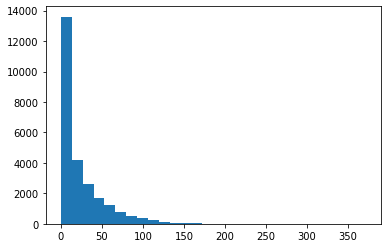

In [ ]:
print(len(max(ref_to, key=len)))
sent_len_to = []
for i in ref_to:
  sent_len_to.append(len(i))

plt.hist(sent_len_to,bins=28)
plt.show()

2477


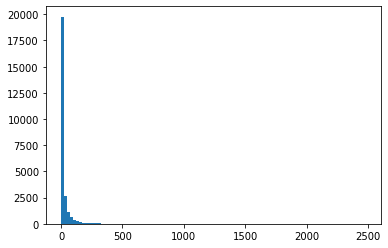

In [ ]:
print(len(max(ref_from, key=len)))
sent_len_from = []
for i in ref_from:
  sent_len_from.append(len(i))

plt.hist(sent_len_from,bins=100)
plt.show()

2340


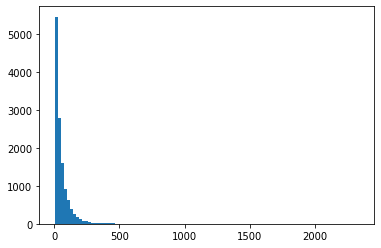

In [ ]:
print(len(max(merged, key=len)))
sent_len_merged = []
for i in merged:
  sent_len_merged.append(len(i))

plt.hist(sent_len_merged,bins=100)
plt.show()

In [ ]:
# tokenize train data (on the whole set of labeled data)
X = tokenizer.texts_to_sequences(train.title)
X = pad_sequences(X, maxlen=20)

X_to = tokenizer.texts_to_sequences(train3.ref_to)
X_to = pad_sequences(X_to, maxlen=100)

X_from = tokenizer.texts_to_sequences(train3.ref_from)
X_from = pad_sequences(X_from, maxlen=100)

X_merged = tokenizer.texts_to_sequences(train3.merged)
X_merged = pad_sequences(X_merged, maxlen=200)

In [ ]:
# TOKENIZE TEST SET

X_new = tokenizer.texts_to_sequences(test3.title)
X_new = pad_sequences(X_new, maxlen=20)

X_new_to = tokenizer.texts_to_sequences(test3.ref_to)
X_new_to = pad_sequences(X_new_to, maxlen=100)

X_new_from = tokenizer.texts_to_sequences(test3.ref_from)
X_new_from = pad_sequences(X_new_from, maxlen=100)

X_new_merged = tokenizer.texts_to_sequences(test3.merged)
X_new_merged = pad_sequences(X_new_merged, maxlen=200)

In [ ]:
X[:10]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  123,
         239,  421,    2,  766,    9,  133,    5,    8,  176],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   49, 2612, 1299,   58,    4,  428,   57],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        2432,   56,  210, 6588,  530,    2, 2142,  980,  476],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 6589,    3,  346,    9,   17,   46,   16],
       [   0,    0,    0,    0,  924,  568,   30,  156,    2,  484, 1626,
           5,   45,  662,    5,    6,  106,    2,  123,   35],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  266,  825,    2, 1897,    5, 1898,  192],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 6590,
           3,  127,   65,  375,   14,    7, 1300,  433,   26],
       [   0,    0,    0,    0,    0,    

In [ ]:
X_to[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  142,  118,    1,  836,  119,   18,   19, 4360,
          3,   90,   57, 1329,   18,   63,  617,  102,    4,   49,  596,
        559,  988,  634,    9,  180,   58], dtype=int32)

In [ ]:
X_from[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 1081,  651,   83,    1,    3,  195,
          2,  165,   83,   40,   53,   23,   48,  517, 3438,    2,  663,
          5,    6, 6095,   23,   43,   16], dtype=int32)

In [ ]:
X_merged[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,   49, 2612, 1299,   58,    4,  4

In [ ]:
# MAKE A SECOND DATA SPLIT
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(X, Y, test_size=0.2, random_state=245, shuffle=True)
X_to_train_, X_to_test_, X_from_train_, X_from_test_ = train_test_split(X_to,X_from, test_size=0.2, random_state=245, shuffle=True)
X_merged_train_, X_merged_test_ = train_test_split(X_merged, test_size=0.2, random_state=245, shuffle=True)
X_train2_, X_test2_ = train_test_split(np.array(train2), test_size=0.2, random_state=245, shuffle=True)

In [ ]:
X_to_train_[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   11,  172,   27,   20,    9,   10, 1798,   60,   24,
         143,  146,    7,  516,   23, 1962],
       [ 699,   35,  484,  161,    5,    3, 3142,   34, 1686,   51,   12,
        1686, 2576,    4, 2181, 2576,  237,    3,  716, 2032,    2,   34,
         378,  102,   52,   71,    2,   34, 1686,  329,  919, 2513,  586,
         237,    1,   34,   51,  863,    6,  307, 2446,    5,   34,  378,
         311,  152, 12

### Training models + summary

"Merged" means titles were merged in the following order: "title" + "ref_to" + "ref_from".

3 separate embeddings means that "title" + "ref_to" + "ref_from" were inputed as three diff. embeddings (in diferent layers).

3 concatenated embeddings means that "title" + "ref_to" + "ref_from" were concatenated (all with their paddings) before feeding to a model.

 in/out ref max size means per type of reference (eg. 50 per ref_to, 50 per ref_from). 


| Titles and in/out   refs  | Model                                    | Max input1 length                            | Max input2 length               | Loss   | Accuracy | Epoch |
|---------------------------|------------------------------------------|----------------------------------------------|---------------------------------|--------|----------|-------|
|                           |                                          | title size or merged title+ref size + references | in/out ref max size (*2) |        |          |       |
| Merged                    | CNN(emb=100,hu=500,k=3,dense=250)        | 20                                           |  --                             | 0.6269 | 0.7883   | 3     |
| Merged                    | CNN(emb=100,hu=500,k=3,dense=250)        | 50                                           |  --                             | 0.5589 | 0.8009   | 3     |
| Merged                    | CNN(emb=100,hu=500,k=3,dense=250)        | 50                                           |  --                             | 0.56   | 0.8009   | 2     |
| Merged                    | CNN(emb=100,hu=500,k=3,dense=250)        | 100                                          |  --                             | 0.54   | 0.802    | 2     |
| Merged                    | CNN(emb=100,hu=500,k=3,dense=250)        | 200                                          |  --                             | **0.5304** | 0.8016   | 2     |
|                           |                                          |                                              |                                 |        |          |       |
| Merged                    | LSTM(emb=128,hu=128)                     | 50                                           |  --                             | 0.5494 | 0.8044   | 4     |
| Merged                    | LSTM(emb=128,hu=128)                     | 100                                          |  --                             | 0.5704 | 0.7989   | 3     |
| Merged                    | LSTM(emb=128,hu=128)                     | 200                                          |  --                             | **0.5435** | **0.8114**   | 4     |
|                           |                                          |                                              |                                 |        |          |       |
| Merged                    | CNN(emb=100, ks=3,4,5, hu=100,dense=500) | 50                                           |  --                             | 0.5426 | 0.8059   | 2     |
| Merged                    | CNN(emb=100, ks=3,4,5, hu=100,dense=500) | 100                                          |  --                             |        |          |       |
| Merged                    | CNN(emb=100, ks=3,4,5, hu=100,dense=500) | 200                                          |  --                             | 0.5441 | 0.8009   | 2     |
|                           |                                          |                                              |                                 |        |          |       |
| 3 separate embeddings     | CNN(emb=100,k=3,hu=100,dense=500)        | 20                                           | 50                              | 0.5524 | 0.7985   | 3     |
| 3 separate embeddings     | CNN(emb=100,k=3,hu=100,dense=500)        | 20                                           | 100                             | 0.5519 | 0.8024   | 3     |
|                           |                                          |                                              |                                 |        |          |       |
| 3 concatenated embeddings | CNN(emb=100,k=3,hu=500,dense=250)        | 20                                           | 100                             | 0.5387 | 0.802    | 2     |
| 3 concatenated embeddings | CNN(emb=100,k=3,hu=500,dense=250)        | 20                                           | 100                             | 0.5487 | 0.8056   | 3     |
|                           |                                          |                                              |                                 |        |          |       |
| 3 concatenated embeddings | CNN(emb=100, ks=3,4,5, hu=100,dense=500) | 20                                           | 50                              | 0.5815 | 0.8087   | 2     |
| 3 concatenated embeddings | CNN(emb=100, ks=3,4,5, hu=100,dense=500) | 20                                           | 100                             | 0.5494 | 0.8083   | 3     |
| 3 concatenated embeddings | CNN(emb=100, ks=4,6,8, hu=100,dense=500) | 20                                           | 50                              | **0.5402** | **0.8071**   | 4     |
| 3 concatenated embeddings | CNN(emb=100, ks=4,6,8, hu=100,dense=500) | 20                                           | 100                             | **0.5351** | **0.8075**   | 3     |
|                           |                                          |                                              |                                 |        |          |       |
| 3 concatenated embeddings | LSTM(emb=128,hu=128), RMSprop lr=0.01    | 20                                           | 50                              | 0.5632 | 0.8052   | 3     |
| 3 concatenated embeddings | LSTM(emb=128,hu=128), RMSprop lr=0.01    | 20                                           | 100                             | 0.596  | 0.7903   | 4     |

#### With only MERGED titles/refs

##### CNN

In [ ]:
# with input_length=20

np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len3 + 1, output_dim=100,
                    input_length=20))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 
model.evaluate(X_test, Y_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 100)           1327400   
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 500)           150500    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 500)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               125250    
_________________________________________________________________
activation_11 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                

[3.1248556922112645, 0.2519562]

In [ ]:
# with input_length=50

np.random.seed(42)
random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(1234) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len3 + 1, output_dim=100,
                    input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           1327400   
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 500)           150500    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 500)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 250)               125250    
_________________________________________________________________
activation_14 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 5)                

In [ ]:
# with input_length=50, compatible seed with other models below

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len3 + 1, output_dim=100,input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model.summary()
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 19s 2ms/sample - loss: 0.9057 - accuracy: 0.6540 - val_loss: 0.6246 - val_accuracy: 0.7825
Epoch 2/5
10223/10223 [==============================] - 18s 2ms/sample - loss: 0.5097 - accuracy: 0.8180 - val_loss: 0.5600 - val_accuracy: 0.8009
Epoch 3/5
10223/10223 [==============================] - 18s 2ms/sample - loss: 0.4058 - accuracy: 0.8532 - val_loss: 0.5852 - val_accuracy: 0.7872
Epoch 4/5
10223/10223 [==============================] - 18s 2ms/sample - loss: 0.3322 - accuracy: 0.8834 - val_loss: 0.5718 - val_accuracy: 0.7938
Epoch 5/5
10223/10223 [==============================] - 18s 2ms/sample - loss: 0.2677 - accuracy: 0.9079 - val_loss: 0.6291 - val_accuracy: 0.7844


In [ ]:
# with input_length=100, compatible seed with other models below

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len3 + 1, output_dim=100,input_length=100))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model.summary()
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 30s 3ms/sample - loss: 0.8891 - accuracy: 0.6665 - val_loss: 0.6107 - val_accuracy: 0.7840
Epoch 2/5
10223/10223 [==============================] - 29s 3ms/sample - loss: 0.4963 - accuracy: 0.8226 - val_loss: 0.5400 - val_accuracy: 0.8020
Epoch 3/5
10223/10223 [==============================] - 29s 3ms/sample - loss: 0.3934 - accuracy: 0.8587 - val_loss: 0.5555 - val_accuracy: 0.7969
Epoch 4/5
10223/10223 [==============================] - 29s 3ms/sample - loss: 0.3268 - accuracy: 0.8856 - val_loss: 0.5519 - val_accuracy: 0.7958
Epoch 5/5
10223/10223 [==============================] - 29s 3ms/sample - loss: 0.2644 - accuracy: 0.9104 - val_loss: 0.5987 - val_accuracy: 0.7887


In [ ]:
# with input_length=200, compatible seed with other models below

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 

kernel_size = 3

model = Sequential()
model.add(Embedding(dict_len3 + 1, output_dim=100,input_length=200))
model.add(Dropout(0.2))
model.add(Conv1D(500,
                 kernel_size,
#  "valid" means "no padding". "same" results in padding the input such that the output has the same length as the original input.
                 padding='same', # changed padding here; 0.78p better with "same"
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(250))
# model.add(Dropout(0.2)) # REMOVED DROPOUT HERE
model.add(Activation('relu'))
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# model.summary()
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 53s 5ms/sample - loss: 0.8956 - accuracy: 0.6660 - val_loss: 0.6186 - val_accuracy: 0.7813
Epoch 2/5
10223/10223 [==============================] - 52s 5ms/sample - loss: 0.4962 - accuracy: 0.8231 - val_loss: 0.5304 - val_accuracy: 0.8016
Epoch 3/5
10223/10223 [==============================] - 53s 5ms/sample - loss: 0.3924 - accuracy: 0.8587 - val_loss: 0.5562 - val_accuracy: 0.7981
Epoch 4/5
10223/10223 [==============================] - 54s 5ms/sample - loss: 0.3222 - accuracy: 0.8866 - val_loss: 0.5579 - val_accuracy: 0.7989
Epoch 5/5
10223/10223 [==============================] - 54s 5ms/sample - loss: 0.2626 - accuracy: 0.9078 - val_loss: 0.5904 - val_accuracy: 0.7962


##### CNN from paper

In [ ]:
# input length = 50

def custom_CNN(input_length=50,vocab_size=dict_len3+1,emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge CNN output with reference stats
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_CNN(input_length=50, vocab_size=dict_len3+1,emb_dim = 100)
history = model.fit(x=[X_merged_train_,X_merged_train_,X_merged_train_], y=Y_train_, 
                    validation_data = ([X_merged_test_,X_merged_test_,X_merged_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 26s 3ms/sample - loss: 0.8278 - accuracy: 0.6861 - val_loss: 0.5671 - val_accuracy: 0.8059
Epoch 2/5
10223/10223 [==============================] - 25s 2ms/sample - loss: 0.4121 - accuracy: 0.8539 - val_loss: 0.5426 - val_accuracy: 0.8059
Epoch 3/5
10223/10223 [==============================] - 24s 2ms/sample - loss: 0.2517 - accuracy: 0.9103 - val_loss: 0.5958 - val_accuracy: 0.7950
Epoch 4/5
10223/10223 [==============================] - 23s 2ms/sample - loss: 0.1169 - accuracy: 0.9610 - val_loss: 0.7285 - val_accuracy: 0.7762
Epoch 5/5
10223/10223 [==============================] - 23s 2ms/sample - loss: 0.0476 - accuracy: 0.9855 - val_loss: 0.8951 - val_accuracy: 0.7833


In [ ]:
# input length = 100

def custom_CNN(input_length=100,vocab_size=dict_len3+1,emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge CNN output with reference stats
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_CNN(input_length=100, vocab_size=dict_len3+1,emb_dim = 100)
history = model.fit(x=[X_merged_train_,X_merged_train_,X_merged_train_], y=Y_train_, 
                    validation_data = ([X_merged_test_,X_merged_test_,X_merged_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 44s 4ms/sample - loss: 0.8429 - accuracy: 0.6908 - val_loss: 0.5740 - val_accuracy: 0.8036
Epoch 2/5
10223/10223 [==============================] - 43s 4ms/sample - loss: 0.4068 - accuracy: 0.8554 - val_loss: 0.5339 - val_accuracy: 0.8056
Epoch 3/5
10223/10223 [==============================] - 43s 4ms/sample - loss: 0.2452 - accuracy: 0.9130 - val_loss: 0.6049 - val_accuracy: 0.7915
Epoch 4/5
10223/10223 [==============================] - 43s 4ms/sample - loss: 0.1163 - accuracy: 0.9597 - val_loss: 0.7270 - val_accuracy: 0.7852
Epoch 5/5
10223/10223 [==============================] - 42s 4ms/sample - loss: 0.0487 - accuracy: 0.9855 - val_loss: 0.9034 - val_accuracy: 0.7817


In [ ]:
# input length = 200

def custom_CNN(input_length=200,vocab_size=dict_len3+1,emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # merge CNN output with reference stats
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_CNN(input_length=200, vocab_size=dict_len3+1,emb_dim = 100)
history = model.fit(x=[X_merged_train_,X_merged_train_,X_merged_train_], y=Y_train_, 
                    validation_data = ([X_merged_test_,X_merged_test_,X_merged_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 91s 9ms/sample - loss: 0.8777 - accuracy: 0.6860 - val_loss: 0.5883 - val_accuracy: 0.7966
Epoch 2/5
10223/10223 [==============================] - 89s 9ms/sample - loss: 0.4118 - accuracy: 0.8543 - val_loss: 0.5441 - val_accuracy: 0.8009
Epoch 3/5
10223/10223 [==============================] - 89s 9ms/sample - loss: 0.2574 - accuracy: 0.9094 - val_loss: 0.6205 - val_accuracy: 0.7903
Epoch 4/5
10223/10223 [==============================] - 90s 9ms/sample - loss: 0.1272 - accuracy: 0.9544 - val_loss: 0.7325 - val_accuracy: 0.7860
Epoch 5/5
10223/10223 [==============================] - 89s 9ms/sample - loss: 0.0535 - accuracy: 0.9848 - val_loss: 0.9590 - val_accuracy: 0.7766


##### LSTM

In [ ]:
# with input_length=50

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 
model = Sequential() 
model.add(Embedding(dict_len3 + 1, 128, input_length=50)) # adding trainable=True does not change thre result, trainable by default?
model.add(LSTM(128, dropout=0.2)) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 25s 2ms/sample - loss: 0.9646 - accuracy: 0.6368 - val_loss: 0.6451 - val_accuracy: 0.7739
Epoch 2/5
10223/10223 [==============================] - 23s 2ms/sample - loss: 0.5355 - accuracy: 0.8144 - val_loss: 0.5962 - val_accuracy: 0.7793
Epoch 3/5
10223/10223 [==============================] - 24s 2ms/sample - loss: 0.4409 - accuracy: 0.8485 - val_loss: 0.5673 - val_accuracy: 0.7977
Epoch 4/5
10223/10223 [==============================] - 23s 2ms/sample - loss: 0.3812 - accuracy: 0.8692 - val_loss: 0.5493 - val_accuracy: 0.8044
Epoch 5/5
10223/10223 [==============================] - 23s 2ms/sample - loss: 0.3376 - accuracy: 0.8833 - val_loss: 0.5908 - val_accuracy: 0.7770


In [ ]:
# with input_length=100

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 
model = Sequential() 
model.add(Embedding(dict_len3 + 1, 128, input_length=100)) # adding trainable=True does not change thre result, trainable by default?
model.add(LSTM(128, dropout=0.2)) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=5) 

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 46s 4ms/sample - loss: 0.9743 - accuracy: 0.6359 - val_loss: 0.6593 - val_accuracy: 0.7625
Epoch 2/5
10223/10223 [==============================] - 44s 4ms/sample - loss: 0.5334 - accuracy: 0.8164 - val_loss: 0.5756 - val_accuracy: 0.7891
Epoch 3/5
10223/10223 [==============================] - 45s 4ms/sample - loss: 0.4395 - accuracy: 0.8508 - val_loss: 0.5704 - val_accuracy: 0.7989
Epoch 4/5
10223/10223 [==============================] - 45s 4ms/sample - loss: 0.3811 - accuracy: 0.8706 - val_loss: 0.5720 - val_accuracy: 0.7934
Epoch 5/5
10223/10223 [==============================] - 45s 4ms/sample - loss: 0.3379 - accuracy: 0.8837 - val_loss: 0.5809 - val_accuracy: 0.7860


In [ ]:
# with input_length=200

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5) 
model = Sequential() 
model.add(Embedding(dict_len3 + 1, 128, input_length=200)) # adding trainable=True does not change thre result, trainable by default?
model.add(LSTM(128, dropout=0.2)) 
model.add(Dense(5, activation="softmax"))  
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
history = model.fit(X_merged_train_, Y_train_, validation_data = (X_merged_test_, Y_test_), batch_size=64, epochs=4) 

Train on 10223 samples, validate on 2556 samples
Epoch 1/4
10223/10223 [==============================] - 91s 9ms/sample - loss: 0.9704 - accuracy: 0.6357 - val_loss: 0.6615 - val_accuracy: 0.7578
Epoch 2/4
10223/10223 [==============================] - 89s 9ms/sample - loss: 0.5343 - accuracy: 0.8153 - val_loss: 0.5484 - val_accuracy: 0.7938
Epoch 3/4
10223/10223 [==============================] - 89s 9ms/sample - loss: 0.4407 - accuracy: 0.8498 - val_loss: 0.5654 - val_accuracy: 0.7993
Epoch 4/4
10223/10223 [==============================] - 89s 9ms/sample - loss: 0.3814 - accuracy: 0.8671 - val_loss: 0.5435 - val_accuracy: 0.8114


In [ ]:
# X_new = tokenizer.texts_to_sequences(train.title)
# X_new = pad_sequences(X_new, maxlen=20)

# X_new_to = tokenizer.texts_to_sequences(train3.ref_to)
# X_new_to = pad_sequences(X_new_to, maxlen=100)

# X_new_from = tokenizer.texts_to_sequences(train3.ref_from)
# X_new_from = pad_sequences(X_new_from, maxlen=100)

# X_new_merged = tokenizer.texts_to_sequences(train3.merged)
# X_new_merged = pad_sequences(X_new_merged, maxlen=200)

##### Predict on test set for kaggle (10th upload)

In [ ]:
Y_new10 = model.predict(x=X_new_merged)

In [ ]:
Y_new10[:3] # results before softmax are shown

array([[8.8813621e-01, 3.4839161e-02, 1.7492132e-02, 3.0435205e-03,
        5.6489006e-02],
       [8.5078202e-02, 1.2647440e-02, 8.9278609e-01, 6.2744338e-03,
        3.2138061e-03],
       [8.9990628e-01, 8.4698750e-03, 3.7087988e-02, 4.6848823e-04,
        5.4067414e-02]], dtype=float32)

In [ ]:
# pick the label with max score.
flat_predictions = np.argmax(Y_new10, axis=1).flatten()

In [ ]:
flat_predictions

array([0, 2, 0, ..., 0, 2, 0])

In [ ]:
test10 = pd.DataFrame(list(zip(test['id'], flat_predictions)), 
               columns = ['id', 'label'])
test10
test10.to_csv('test10.csv',index=False)

#### With separate embeddings for titles and in/out references

##### CNN 3 diff embeddings, kernel = 3, filters = 100

In [ ]:
# with input_length2=50

def custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length2,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length2,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 13s 1ms/sample - loss: 0.9312 - accuracy: 0.6447 - val_loss: 0.6852 - val_accuracy: 0.7723
Epoch 2/5
10223/10223 [==============================] - 12s 1ms/sample - loss: 0.4599 - accuracy: 0.8395 - val_loss: 0.5899 - val_accuracy: 0.7856
Epoch 3/5
10223/10223 [==============================] - 12s 1ms/sample - loss: 0.3224 - accuracy: 0.8849 - val_loss: 0.5524 - val_accuracy: 0.7985
Epoch 4/5
10223/10223 [==============================] - 12s 1ms/sample - loss: 0.2278 - accuracy: 0.9227 - val_loss: 0.5534 - val_accuracy: 0.7930
Epoch 5/5
10223/10223 [==============================] - 12s 1ms/sample - loss: 0.1532 - accuracy: 0.9498 - val_loss: 0.5866 - val_accuracy: 0.7879


In [ ]:
# with input_length2=100

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  emb1 = Embedding(vocab_size, emb_dim)(inputs1)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  inputs2 = Input(shape=(input_length2,))
  emb2 = Embedding(vocab_size, emb_dim)(inputs2)
  conv2 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  inputs3 = Input(shape=(input_length2,))
  emb3 = Embedding(vocab_size, emb_dim)(inputs3)
  conv3 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 20s 2ms/sample - loss: 0.9292 - accuracy: 0.6424 - val_loss: 0.6792 - val_accuracy: 0.7778
Epoch 2/5
10223/10223 [==============================] - 19s 2ms/sample - loss: 0.4591 - accuracy: 0.8376 - val_loss: 0.5857 - val_accuracy: 0.7907
Epoch 3/5
10223/10223 [==============================] - 19s 2ms/sample - loss: 0.3231 - accuracy: 0.8853 - val_loss: 0.5519 - val_accuracy: 0.8024
Epoch 4/5
10223/10223 [==============================] - 19s 2ms/sample - loss: 0.2321 - accuracy: 0.9202 - val_loss: 0.5557 - val_accuracy: 0.7919
Epoch 5/5
10223/10223 [==============================] - 19s 2ms/sample - loss: 0.1586 - accuracy: 0.9467 - val_loss: 0.5718 - val_accuracy: 0.7911


#### With concatenated embeddings for titles and in/out references

##### Simple CNN

In [ ]:
# with input_length2=100

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  drop1 = Dropout(0.2)(emb1)
  conv1 = Conv1D(filters=500, kernel_size=3, padding='same', activation='relu', strides=1)(drop1)
  pool1 = GlobalMaxPooling1D()(conv1)
  flat1 = Flatten()(pool1)

  dense1 = Dense(250, activation='relu')(flat1)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  # rmsprop = optimizers.RMSprop(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

# define model
model = custom_model(input_length=20, input_length2=100,vocab_size=13273+1,emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 58s 6ms/sample - loss: 0.8964 - accuracy: 0.6669 - val_loss: 0.6232 - val_accuracy: 0.7801
Epoch 2/5
10223/10223 [==============================] - 57s 6ms/sample - loss: 0.4992 - accuracy: 0.8208 - val_loss: 0.5387 - val_accuracy: 0.8020
Epoch 3/5
10223/10223 [==============================] - 57s 6ms/sample - loss: 0.4001 - accuracy: 0.8571 - val_loss: 0.5487 - val_accuracy: 0.8056
Epoch 4/5
10223/10223 [==============================] - 57s 6ms/sample - loss: 0.3319 - accuracy: 0.8837 - val_loss: 0.5653 - val_accuracy: 0.7942
Epoch 5/5
10223/10223 [==============================] - 57s 6ms/sample - loss: 0.2720 - accuracy: 0.9064 - val_loss: 0.6137 - val_accuracy: 0.7829


##### CNN with kernels=3,4,5 and 4,6,8, one concatenated embedding.

In [ ]:
# with input_length2=50
# kernels = 3,4,5

def custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  emb2 = Embedding(vocab_size, emb_dim)(merged)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  emb3 = Embedding(vocab_size, emb_dim)(merged)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 36s 3ms/sample - loss: 0.8285 - accuracy: 0.6928 - val_loss: 0.6628 - val_accuracy: 0.7962
Epoch 2/5
10223/10223 [==============================] - 34s 3ms/sample - loss: 0.4385 - accuracy: 0.8418 - val_loss: 0.5815 - val_accuracy: 0.8087
Epoch 3/5
10223/10223 [==============================] - 34s 3ms/sample - loss: 0.3254 - accuracy: 0.8831 - val_loss: 0.5563 - val_accuracy: 0.8052
Epoch 4/5
10223/10223 [==============================] - 34s 3ms/sample - loss: 0.2395 - accuracy: 0.9192 - val_loss: 0.5487 - val_accuracy: 0.8016
Epoch 5/5
10223/10223 [==============================] - 33s 3ms/sample - loss: 0.1728 - accuracy: 0.9401 - val_loss: 0.5854 - val_accuracy: 0.7856


In [ ]:
# with input_length2=50
# kernels = 4,6,8

def custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  conv1 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  emb2 = Embedding(vocab_size, emb_dim)(merged)
  conv2 = Conv1D(filters=100, kernel_size=6, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  emb3 = Embedding(vocab_size, emb_dim)(merged)
  conv3 = Conv1D(filters=100, kernel_size=8, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 49s 5ms/sample - loss: 0.8278 - accuracy: 0.6905 - val_loss: 0.6520 - val_accuracy: 0.8020
Epoch 2/5
10223/10223 [==============================] - 48s 5ms/sample - loss: 0.4276 - accuracy: 0.8481 - val_loss: 0.5850 - val_accuracy: 0.8052
Epoch 3/5
10223/10223 [==============================] - 48s 5ms/sample - loss: 0.3084 - accuracy: 0.8895 - val_loss: 0.5558 - val_accuracy: 0.8048
Epoch 4/5
10223/10223 [==============================] - 48s 5ms/sample - loss: 0.2155 - accuracy: 0.9251 - val_loss: 0.5402 - val_accuracy: 0.8071
Epoch 5/5
10223/10223 [==============================] - 49s 5ms/sample - loss: 0.1491 - accuracy: 0.9523 - val_loss: 0.5986 - val_accuracy: 0.7833


In [ ]:
# with input_length2=100
# kernels = 3,4,5

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  conv1 = Conv1D(filters=100, kernel_size=3, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  emb2 = Embedding(vocab_size, emb_dim)(merged)
  conv2 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  emb3 = Embedding(vocab_size, emb_dim)(merged)
  conv3 = Conv1D(filters=100, kernel_size=5, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 60s 6ms/sample - loss: 0.8250 - accuracy: 0.6939 - val_loss: 0.6545 - val_accuracy: 0.7938
Epoch 2/5
10223/10223 [==============================] - 59s 6ms/sample - loss: 0.4406 - accuracy: 0.8443 - val_loss: 0.5868 - val_accuracy: 0.7997
Epoch 3/5
10223/10223 [==============================] - 59s 6ms/sample - loss: 0.3247 - accuracy: 0.8862 - val_loss: 0.5493 - val_accuracy: 0.8083
Epoch 4/5
10223/10223 [==============================] - 59s 6ms/sample - loss: 0.2395 - accuracy: 0.9175 - val_loss: 0.5501 - val_accuracy: 0.7934
Epoch 5/5
10223/10223 [==============================] - 60s 6ms/sample - loss: 0.1683 - accuracy: 0.9396 - val_loss: 0.5480 - val_accuracy: 0.8005


In [ ]:
# with input_length2=100
# kernels = 4,6,8

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  conv1 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  emb2 = Embedding(vocab_size, emb_dim)(merged)
  conv2 = Conv1D(filters=100, kernel_size=6, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  emb3 = Embedding(vocab_size, emb_dim)(merged)
  conv3 = Conv1D(filters=100, kernel_size=8, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=3) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/3
10223/10223 [==============================] - 83s 8ms/sample - loss: 0.8238 - accuracy: 0.6932 - val_loss: 0.6508 - val_accuracy: 0.8024
Epoch 2/3
10223/10223 [==============================] - 82s 8ms/sample - loss: 0.4227 - accuracy: 0.8481 - val_loss: 0.5830 - val_accuracy: 0.8013
Epoch 3/3
10223/10223 [==============================] - 82s 8ms/sample - loss: 0.3017 - accuracy: 0.8917 - val_loss: 0.5351 - val_accuracy: 0.8075


###### Predict on test set for kaggle (11th upload) - 81.77%

In [ ]:
Y_new11 = model.predict(x=[X_new, X_new_to, X_new_from])

In [ ]:
Y_new11[:3] # results before softmax are shown

array([[0.7271129 , 0.17593327, 0.03700046, 0.03728134, 0.02267204],
       [0.20437443, 0.06697048, 0.7124184 , 0.00811259, 0.00812415],
       [0.82428205, 0.07986361, 0.07299255, 0.00736944, 0.01549236]],
      dtype=float32)

In [ ]:
# pick the label with max score.
flat_predictions = np.argmax(Y_new11, axis=1).flatten()

In [ ]:
flat_predictions

array([0, 2, 0, ..., 0, 2, 0])

In [ ]:
test11 = pd.DataFrame(list(zip(test['id'], flat_predictions)), 
               columns = ['id', 'label'])
test11
test11.to_csv('test11.csv',index=False)

##### Run model on the whole training data set

In [ ]:
# with input_length2=100
# kernels = 4,6,8

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  conv1 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  emb2 = Embedding(vocab_size, emb_dim)(merged)
  conv2 = Conv1D(filters=100, kernel_size=6, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  emb3 = Embedding(vocab_size, emb_dim)(merged)
  conv3 = Conv1D(filters=100, kernel_size=8, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100)
model.fit(x=[X,X_to,X_from], y=Y, batch_size=64, epochs=3) 
# save the model
# model.save('model.h5')

Train on 12779 samples
Epoch 1/3
12779/12779 [==============================] - 98s 8ms/sample - loss: 0.7745 - accuracy: 0.7097
Epoch 2/3
12779/12779 [==============================] - 97s 8ms/sample - loss: 0.4171 - accuracy: 0.8510
Epoch 3/3
12779/12779 [==============================] - 97s 8ms/sample - loss: 0.3121 - accuracy: 0.8891


###### Predict on test set for kaggle (13th upload) - 82.1% on Kaggle.

Using the whole training set for training. 

In [ ]:
Y_new13 = model.predict(x=[X_new, X_new_to, X_new_from])

In [ ]:
Y_new13[:3] # results before softmax are shown

array([[0.7490175 , 0.20132141, 0.02974566, 0.01197721, 0.00793809],
       [0.28935567, 0.2452781 , 0.44919783, 0.00643598, 0.00973232],
       [0.8710673 , 0.06758085, 0.04683995, 0.00284915, 0.01166281]],
      dtype=float32)

In [ ]:
# pick the label with max score.
flat_predictions = np.argmax(Y_new13, axis=1).flatten()

In [ ]:
flat_predictions

array([0, 2, 0, ..., 0, 2, 0])

In [ ]:
test13 = pd.DataFrame(list(zip(test['id'], flat_predictions)), 
               columns = ['id', 'label'])
test13
test13.to_csv('test13.csv',index=False)

In [ ]:
# with input_length2=100
# kernels = 4,6,8
# dropout = 0.2

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100):
  # define CNN layer
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  conv1 = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu', strides=1)(emb1)
  drop1 = Dropout(0.2)(conv1)
  pool1 = GlobalMaxPooling1D()(drop1) # MaxOverTime
  # pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  emb2 = Embedding(vocab_size, emb_dim)(merged)
  conv2 = Conv1D(filters=100, kernel_size=6, padding='same', activation='relu', strides=1)(emb2)
  drop2 = Dropout(0.2)(conv2)
  pool2 = GlobalMaxPooling1D()(drop2)
  # pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  emb3 = Embedding(vocab_size, emb_dim)(merged)
  conv3 = Conv1D(filters=100, kernel_size=8, padding='same', activation='relu', strides=1)(emb3)
  drop3 = Dropout(0.2)(conv3)
  pool3 = GlobalMaxPooling1D()(drop3)
  # pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)

  # inputs4 = Input(shape=(input_length2,))

  # merge CNN output with reference stats
  # merged = concatenate([flat1, flat2, flat3, inputs4])
  merged = concatenate([flat1, flat2, flat3])

  dense1 = Dense(500, activation='relu')(merged)
  outputs = Dense(5, activation="softmax")(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs) # , inputs4
  model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
  # print(model.summary())
  # plot_model(model, show_shapes=True, to_file='multichannel.png')
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 100)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Train on 10223 samples, validate on 2556 samples
Epoch 1/5
10223/10223 [==============================] - 83s 8ms/sample - loss: 0.8323 - accuracy: 0.6883 - val_loss: 0.5742 - val_accuracy: 0.8001
Epoch 2/5
10223/10223 [==============================] - 82s 8ms/sample - loss: 0.4077 - accuracy: 0.8543 - val_loss: 0.5367 - val_accuracy: 0.8009
Epoch 3/5
10223/10223 [==============================] - 82s 8ms/sample - loss: 0.2604 - accuracy: 0.9067 - val_loss: 0.5391 - val_accuracy: 0.8067
Epoch 4/5
10223/10223 [==============================] - 83s 8ms/sample - loss: 0.1516 - accuracy: 0.9488 - val_loss: 0.5800 - val_accuracy: 0.8024
Epoch 5/5
10223/10223 [==============================] - 82s 8ms/sample - loss: 0.0754 - accuracy: 0.9769 - val_loss: 0.7006 - val_accuracy: 0.7997


##### LSTM

Set RMSprop lr=0.01 otherwise convergence too slow

In [ ]:
# input_length2=50

def custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 128):
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  lstm = LSTM(128, dropout=0.2)(emb1)
  outputs = Dense(5, activation="softmax")(lstm)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  rmsprop = optimizers.RMSprop(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
  print(model.summary())
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20,input_length2=50,vocab_size=13273+1,emb_dim = 128)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_4 (TensorFlo [(None, 120)]        0           input_13[0][0]                   
                                                                 input_14[0][0]             

In [ ]:
# input_length2=100

def custom_model(input_length=20, input_length2=100, vocab_size=13274, emb_dim = 128):
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  lstm = LSTM(128, dropout=0.2)(emb1)
  outputs = Dense(5, activation="softmax")(lstm)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  rmsprop = optimizers.RMSprop(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
  print(model.summary())
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20,input_length2=100,vocab_size=13273+1,emb_dim = 128)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_63 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_64 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_25 (TensorFl [(None, 220)]        0           input_62[0][0]                   
                                                                 input_63[0][0]            

In [ ]:
# input_length2=50, 2 hidden layers

def custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 128):
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  lstm = LSTM(128, dropout=0.2,return_sequences=True)(emb1)
  lstm2 = LSTM(128, dropout=0.2)(lstm)
  outputs = Dense(5, activation="softmax")(lstm2)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  rmsprop = optimizers.RMSprop(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
  print(model.summary())
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20,input_length2=50,vocab_size=13273+1,emb_dim = 128)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_10 (TensorFl [(None, 120)]        0           input_31[0][0]                   
                                                                 input_32[0][0]             

##### Bi-LSTM

In [ ]:
# input_length2=50

def custom_model(input_length=20, input_length2=50, vocab_size=13274, emb_dim = 128):
  inputs1 = Input(shape=(input_length,))
  inputs2 = Input(shape=(input_length2,))
  inputs3 = Input(shape=(input_length2,))
  merged = concatenate([inputs1, inputs2, inputs3])

  emb1 = Embedding(vocab_size, emb_dim)(merged)
  lstm = Bidirectional(LSTM(128, dropout=0.2))(emb1)
  outputs = Dense(5, activation="softmax")(lstm)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  rmsprop = optimizers.RMSprop(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])
  print(model.summary())
  return model

np.random.seed(5)
random.seed(5)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(5)

model = custom_model(input_length=20,input_length2=50,vocab_size=13273+1,emb_dim = 128)
model.fit(x=[X_train_,X_to_train_,X_from_train_], y=Y_train_, validation_data = ([X_test_,X_to_test_,X_from_test_], Y_test_), batch_size=64, epochs=5) 
# save the model
# model.save('model.h5')

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_concat_8 (TensorFlo [(None, 120)]        0           input_25[0][0]                   
                                                                 input_26[0][0]             